# Inference and Test Set Metric Calculation

This notebook is used for both CNN and Clay model inference on the testset.

## Setup

In [1]:
import sys
import warnings

sys.path.append("../../")
warnings.filterwarnings("ignore")

# set working directory to root 
import os
os.chdir("../../")
root = os.getcwd()
root = root + "/workspaces/mine-segmentation" # for lightning studios
print(f"Root directory: {root}")

Root directory: /teamspace/studios/this_studio/workspaces/mine-segmentation


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
# import leafmap
import torch
import torch.nn.functional as F
# from einops import rearrange
# from matplotlib.colors import ListedColormap
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, recall_score, precision_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
# from shapely.wkt import loads
# import datetime
from pathlib import Path
import random
import shutil
import os

from src.models.datamodule import MineDataModule
from src.models.cnn.model import MineSegmentorCNN
from src.models.clay.segment.model import MineSegmentor


from src.visualization.visualization_funcs import plot_pred_vs_true_mask

In [3]:
# for development
%load_ext autoreload
%autoreload 2

#### Define paths and parameters

In [4]:
# # 2048 model
# MINESEG_CHECKPOINT_PATH = ("models/cnn/2048_mineseg-cnn_epoch-08_val-iou-0.5017.ckpt")
# CHIP_SIZE = 2048
# TESTSET_BATCH_SIZE = 1
# TRAIN_CHIP_DIR = "data/processed/chips/npy/2048/train/chips/"
# TRAIN_LABEL_DIR = " data/processed/chips/npy/2048/train/labels/"
# VAL_CHIP_DIR = "data/processed/chips/npy/2048/val/chips/"
# VAL_LABEL_DIR = "data/processed/chips/npy/2048/val/labels/"
# TEST_CHIP_DIR = "data/processed/chips/npy/2048/test/chips/"
# TEST_LABEL_DIR = "data/processed/chips/npy/2048/test/labels/"
# METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
# CLAY = False


# # 1024 model
# MINESEG_CHECKPOINT_PATH = ("models/cnn/1024_mineseg-cnn_epoch-15_val-iou-0.5290.ckpt")
# CHIP_SIZE = 1024
# TESTSET_BATCH_SIZE = 4
# TRAIN_CHIP_DIR = "data/processed/chips/npy/1024/train/chips/"
# TRAIN_LABEL_DIR = " data/processed/chips/npy/1024/train/labels/"
# VAL_CHIP_DIR = "data/processed/chips/npy/1024/val/chips/"
# VAL_LABEL_DIR = "data/processed/chips/npy/1024/val/labels/"
# TEST_CHIP_DIR = "data/processed/chips/npy/1024/test/chips/"
# TEST_LABEL_DIR = "data/processed/chips/npy/1024/test/labels/"
# METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
# CLAY = False


# 512 model
MINESEG_CHECKPOINT_PATH = ("models/cnn/mineseg-cnn_epoch-16_val-iou-0.5731.ckpt")
CHIP_SIZE = 512
TESTSET_BATCH_SIZE = 16 # 32 for L4, 16 for PC GPU
TRAIN_CHIP_DIR = "data/processed/chips/npy/512/train/chips/"
TRAIN_LABEL_DIR = "data/processed/chips/npy/512/train/labels/"
VAL_CHIP_DIR = "data/processed/chips/npy/512/val/chips/"
VAL_LABEL_DIR = "data/processed/chips/npy/512/val/labels/"
TEST_CHIP_DIR = "data/processed/chips/npy/512/test/chips/"
TEST_LABEL_DIR = "data/processed/chips/npy/512/test/labels/"
TEST_CHIP_VALIDATED_DIR = "data/processed/chips/npy/512/validated/test/chips/"
TEST_LABEL_VALIDATED_DIR = "data/processed/chips/npy/512/validated/test/labels/"
METADATA_PATH = "configs/cnn/cnn_segment_metadata.yaml"
CLAY = False


# # CLAY model
# MINESEG_CHECKPOINT_PATH = "models/clay/mineseg-clay-segment_epoch-00_val-iou-0.3155.ckpt"
# CLAY_CHECKPOINT_PATH = "models/clay-v1-base.ckpt"
# CHIP_SIZE = 512
# TESTSET_BATCH_SIZE = 1
# TRAIN_CHIP_DIR = "data/processed/chips/npy/512/train/chips/"
# TRAIN_LABEL_DIR = "data/processed/chips/npy/512/train/labels/"
# VAL_CHIP_DIR = "data/processed/chips/npy/512/val/chips/"
# VAL_LABEL_DIR = "data/processed/chips/npy/512/val/labels/"
# TEST_CHIP_DIR = "data/processed/chips/npy/512/test/chips/"
# TEST_LABEL_DIR = "data/processed/chips/npy/512/test/labels/"
# METADATA_PATH = "configs/clay/clay_segment_metadata.yaml"
# CLAY = True


# general setup
DATASET = "data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg"
BATCH_SIZE = 1
if torch.cuda.is_available():
    NUM_WORKERS = 16
else:
    NUM_WORKERS = 4
PLATFORM = "sentinel-2-l2a"

In [5]:
if CLAY:
    CLAY_CHECKPOINT_PATH = root + "/" + CLAY_CHECKPOINT_PATH

MINESEG_CHECKPOINT_PATH = root + "/" + MINESEG_CHECKPOINT_PATH
METADATA_PATH = root + "/" + METADATA_PATH
TRAIN_CHIP_DIR = root +  "/" + TRAIN_CHIP_DIR
TRAIN_LABEL_DIR = root + "/" + TRAIN_LABEL_DIR
VAL_CHIP_DIR = root + "/" + VAL_CHIP_DIR
VAL_LABEL_DIR = root + "/" + VAL_LABEL_DIR
TEST_CHIP_DIR = root + "/" + TEST_CHIP_DIR
TEST_LABEL_DIR = root + "/" + TEST_LABEL_DIR
TEST_CHIP_VALIDATED_DIR = root + "/" + TEST_CHIP_VALIDATED_DIR
TEST_LABEL_VALIDATED_DIR = root + "/" + TEST_LABEL_VALIDATED_DIR
DATASET = root + "/" + DATASET

In [6]:
model_name = MINESEG_CHECKPOINT_PATH.split("/")[-1]
print(f"Using model {model_name}")
print(f"Using chip size {CHIP_SIZE}")
print(f"Using test chip dir {TEST_CHIP_DIR}")
print(f"Using test label dir {TEST_LABEL_DIR}")
print(f"Using validated chip dir {TEST_CHIP_VALIDATED_DIR}")
print(f"Using validated label dir {TEST_LABEL_VALIDATED_DIR}")
print(f"Using test batch size {TESTSET_BATCH_SIZE}")
print(f"Using dataset {DATASET}")


Using model mineseg-cnn_epoch-16_val-iou-0.5731.ckpt
Using chip size 512
Using test chip dir /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/test/chips/
Using test label dir /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/test/labels/
Using validated chip dir /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/validated/test/chips/
Using validated label dir /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/validated/test/labels/
Using test batch size 16
Using dataset /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/mining_tiles_with_masks_and_bounding_boxes.gpkg


#### Model Loading

In [7]:
if CLAY:
    def get_model(mineseg_checkpoint_path, clay_checkpoint_path, metadata_path):
        model = MineSegmentor.load_from_checkpoint(
            checkpoint_path=mineseg_checkpoint_path,
            metadata_path=metadata_path,
            ckpt_path=clay_checkpoint_path,
        )
        model.eval()
        return model
else: 
    def get_model(checkpoint_path: str) -> MineSegmentorCNN:
        # check if gpu is available
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        map_location=torch.device(device)
        checkpoint = torch.load(checkpoint_path, map_location=map_location)
        model_config = checkpoint["hyper_parameters"]
        model = MineSegmentorCNN.load_from_checkpoint(checkpoint_path, **model_config)
        model.eval()
        return model

#### Data Preparation

In [8]:
def get_data(
    train_chip_dir,
    train_label_dir,
    val_chip_dir,
    val_label_dir,
    test_chip_dir,
    test_label_dir,
    metadata_path,
    batch_size,
    num_workers,
    platform,
    data_augmentation,
    index=None
):
    dm = MineDataModule(
        train_chip_dir=train_chip_dir,
        train_label_dir=train_label_dir,
        val_chip_dir=val_chip_dir,
        val_label_dir=val_label_dir,
        test_chip_dir=test_chip_dir,
        test_label_dir=test_label_dir,
        metadata_path=metadata_path,
        batch_size=batch_size,
        num_workers=num_workers,
        platform=platform,
        data_augmentation=data_augmentation,
    )
    
    dm.setup(stage="test")
    
    if index is not None:
        test_dl = iter(dm.test_dataloader())
        for i in range(index + 1):
            batch = next(test_dl)
        metadata = dm.metadata
        return batch, metadata
    else:
        test_dl = dm.test_dataloader()
        batch = next(iter(test_dl))
        metadata = dm.metadata
        return batch, metadata

#### Prediction

In [9]:
def run_prediction(model, batch, is_clay=False):
    with torch.no_grad():
        if is_clay:
            image=batch
        else:
            image = batch["pixels"]
        outputs = model(image)
    outputs = F.interpolate(
        outputs, size=(CHIP_SIZE, CHIP_SIZE), mode="bilinear", align_corners=False
    )
    return outputs

#### Post-Processing

In [10]:
def post_process(batch, outputs, metadata, index=0):
    
    outputs = outputs.sigmoid()
    prob_mask = outputs.cpu().numpy()
    pred_mask = (prob_mask > 0.5).astype(float)
    labels = batch["label"].detach().cpu().numpy()
    pixels = batch["pixels"].detach().cpu().numpy()

    # normalize and clip the image ranges
    pixels = (pixels - pixels.min()) / (pixels.max() - pixels.min())
    pixels = np.clip(pixels, 0, 1)

    images = pixels[index]
    labels = labels[index]
    prob_mask = prob_mask[index]
    pred_mask = pred_mask[index].astype(float)

    images = images.transpose((1,2,0))
    prob_mask = prob_mask.transpose((1,2,0))
    pred_mask = pred_mask.transpose((1,2,0)).astype(float)

    # normalize the probablity mask
    # prob_mask = (prob_mask - prob_mask.min()) / (prob_mask.max() - prob_mask.min())

    return images, labels, prob_mask, pred_mask

#### Plotting

In [11]:
def plot_predictions(images, labels, probas, preds):
    fig, axes = plt.subplots(1, 5, figsize=(15, 6))

    # Plot the image
    axes[0].imshow(images)
    axes[0].axis("off")
    axes[0].set_title("Image", fontsize=12)

    # Plot the actual segmentation
    axes[1].imshow(labels, vmin=0, vmax=1)
    axes[1].axis("off")
    axes[1].set_title("Actual", fontsize=12)

    # Plot the predicted segmentation
    axes[2].imshow(preds, vmin=0, vmax=1)
    axes[2].axis("off")
    axes[2].set_title("Pred", fontsize=12)

    # Plot the predicted segmentation
    axes[3].imshow(probas, vmin=0, vmax=1)
    axes[3].axis("off")
    axes[3].set_title("Proba", fontsize=12)

    # Plot the plot_pred_vs_true_mask
    plot_pred_vs_true_mask(images, labels, preds.squeeze(), ax=axes[4], add_legend=False)
    axes[4].set_title("Pred vs True", fontsize=12)

    plt.tight_layout()
    plt.show()

In [12]:
# Load model
if CLAY:
    model = get_model(MINESEG_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH, METADATA_PATH)
else:
    model = get_model(MINESEG_CHECKPOINT_PATH)

Using device: cuda


## Plot example predictions

Plot 4 chips with mining area, and 4 without mining area. 

In [13]:
test_chips = os.listdir(TEST_CHIP_DIR)
test_chips_indices = [test_chips.index(chip) for chip in test_chips]
test_chips_wo_miningarea = [chip for chip in test_chips if "nominearea" in chip]
test_chips_w_miningarea = [chip for chip in test_chips if "nominearea" not in chip]
indices_wo_miningarea = [test_chips.index(chip) for chip in test_chips_wo_miningarea]
indices_w_miningarea = [test_chips.index(chip) for chip in test_chips_w_miningarea]

print(f"Number of all test chips: {len(test_chips)}")
print(f"Number of test chips without mining area: {len(test_chips_wo_miningarea)}")
print(f"Number of test chips with mining area: {len(test_chips_w_miningarea)}")

# take a sample of the chips with mining area 
# random.seed(42)
sample_indices_w_ma = random.sample(indices_w_miningarea, 4)
print(f"Sample indices of chips with mining area: {sample_indices_w_ma}")
if not CHIP_SIZE == 2048:
    sample_indices_wo_ma = random.sample(indices_wo_miningarea, 4)
    print(f"Sample indices of chips without mining area: {sample_indices_wo_ma}")

Number of all test chips: 1843
Number of test chips without mining area: 1062
Number of test chips with mining area: 781
Sample indices of chips with mining area: [1328, 1665, 796, 968]
Sample indices of chips without mining area: [491, 710, 1351, 760]


In [14]:
def plot_sample_predictions(sample_indices):
    for index in sample_indices:

        # Get data
        batch, metadata = get_data(
            TRAIN_CHIP_DIR,
            TRAIN_LABEL_DIR,
            VAL_CHIP_DIR,
            VAL_LABEL_DIR,
            TEST_CHIP_DIR,
            TEST_LABEL_DIR,
            METADATA_PATH,
            BATCH_SIZE,
            NUM_WORKERS,
            PLATFORM,
            data_augmentation=False,
            index=index
        )

        # Move batch to GPU
        if torch.cuda.is_available():
            batch = {k: v.to("cuda") for k, v in batch.items()}

        # Run prediction
        outputs = run_prediction(model, batch, is_clay=CLAY)

        # Post-process the results
        images, labels, probas, preds = post_process(batch, outputs, metadata)

        # Plot the predictions
        plot_predictions(images, labels, probas, preds)

#### Predictions on chips with mining area: 

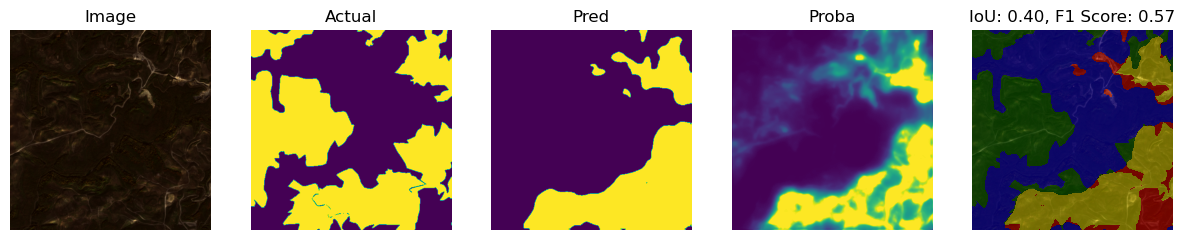

<Figure size 640x480 with 0 Axes>

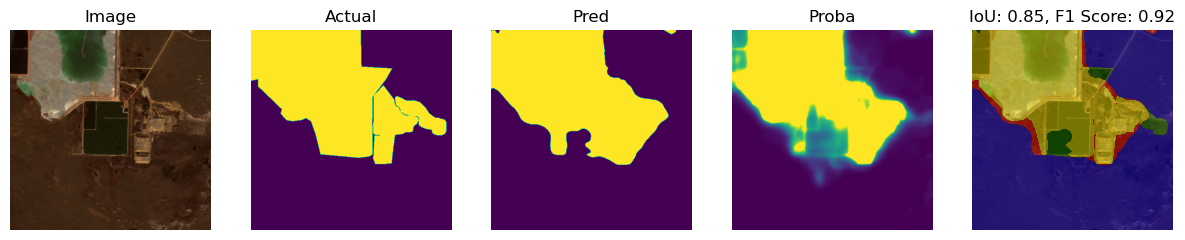

<Figure size 640x480 with 0 Axes>

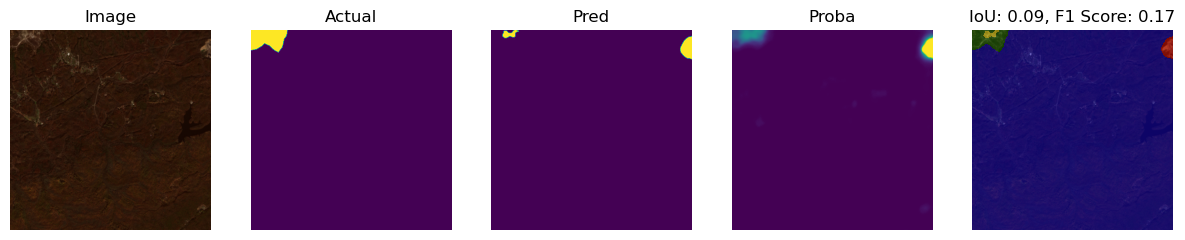

<Figure size 640x480 with 0 Axes>

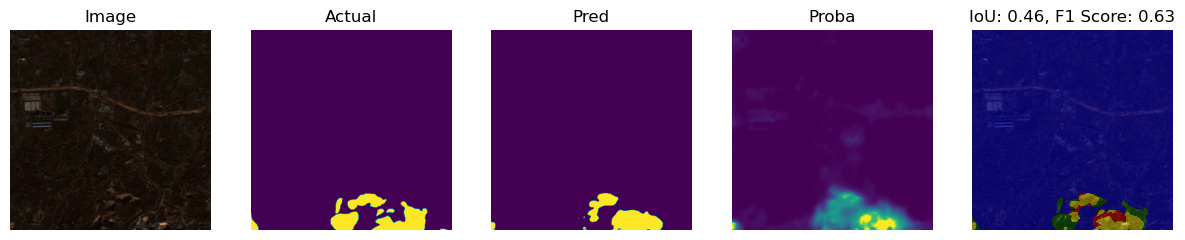

<Figure size 640x480 with 0 Axes>

In [15]:
plot_sample_predictions(sample_indices_w_ma)

#### Predictions on chips without mining area:

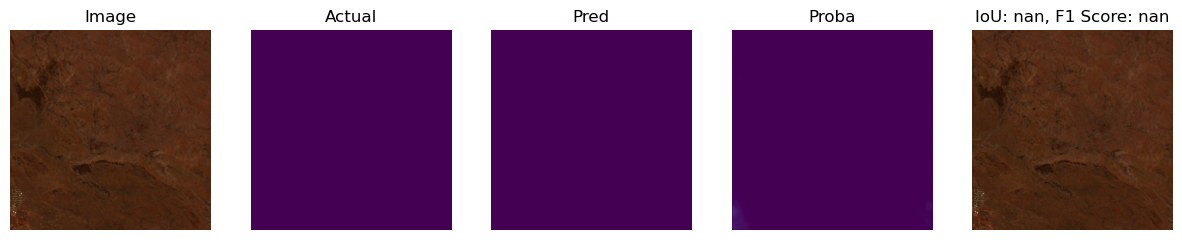

<Figure size 640x480 with 0 Axes>

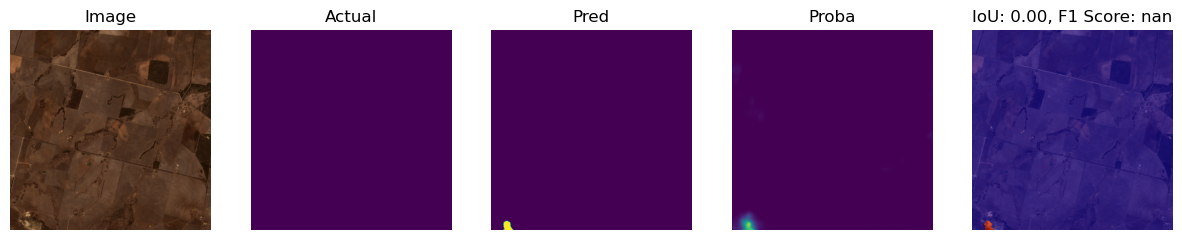

<Figure size 640x480 with 0 Axes>

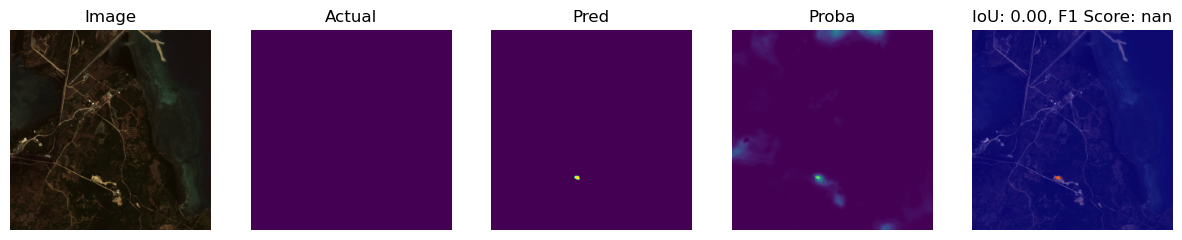

<Figure size 640x480 with 0 Axes>

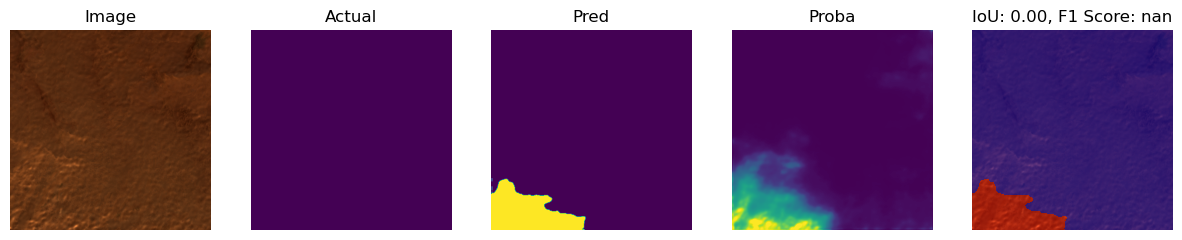

<Figure size 640x480 with 0 Axes>

In [16]:
if not CHIP_SIZE == 2048:
    plot_sample_predictions(sample_indices_wo_ma)

## Metric calculation on test dataset

To calculate the metric on the test dataset, we need to predict the masks for all the chips in the test dataset and then calculate an aggregate metric.


By default, the test set includes only chips with mining area. However, this will cover differently large areas of the actual tiles. Therefore, we will also calculate the metric on the full test set, which includes all chips from the test tiles. This makes models for different chip sizes comparable.

### Define Functions

In [17]:
def copy_files_to_temp_directory(tile_id, test_chip_dir, test_label_dir, temp_chip_dir, temp_label_dir):
    """
    Copies files with the specified tile_id from the test directories to the temporary directories.

    Args:
        tile_id (int): The tile ID to filter the files.
        test_chip_dir (str): The directory containing the test chip files.
        test_label_dir (str): The directory containing the test label files.
        temp_chip_dir (str): The temporary directory to copy the chip files.
        temp_label_dir (str): The temporary directory to copy the label files.

    Returns:
        tuple: A tuple containing the temporary chip directory, temporary label directory, and the last copied chip file.

    """
    # Remove any existing files in the directories
    for chip in os.listdir(temp_chip_dir):
        os.remove(os.path.join(temp_chip_dir, chip))
    for mask in os.listdir(temp_label_dir):
        os.remove(os.path.join(temp_label_dir, mask))

    filenames = []
    # Move chip files with the specified tile_id to the temp directory
    for chip in os.listdir(test_chip_dir):
        if int(chip.split("_")[0]) == tile_id:
            shutil.copy(os.path.join(test_chip_dir, chip), os.path.join(temp_chip_dir, chip))
            # get file name without extension and nominearea addition
            filename = chip.split("_")[0:7]
            filename = "_".join(filename)
            filenames.append(filename)

    # Move mask files with the specified tile_id to the temp directory
    for mask in os.listdir(test_label_dir):
        if int(mask.split("_")[0]) == tile_id:
            shutil.copy(os.path.join(test_label_dir, mask), os.path.join(temp_label_dir, mask))
            filename = mask.split("_")[0:7]
            filename = "_".join(filename)
            filenames.append(filename)

    # make sure that the filenames are all the same
    filenames = list(set(filenames))
    assert len(filenames) == 1, "Filenames are not all the same"

    # print(f"Number of chips: {len(os.listdir(temp_chip_dir))}")
    # print(f"Number of masks: {len(os.listdir(temp_label_dir))}")
    # print("Filename: ", filename)

    return filename

In [66]:
import time

def calculate_metrics(
        model, 
        test_chip_dir, 
        test_label_dir,
        testset_batch_size, 
        calculate_per_tile=False
    ):
    """
    Calculates various metrics for evaluating the performance of a model on a test dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        test_chip_dir (str): The directory containing the test dataset chips.
        test_label_dir (str): The directory containing the test dataset labels.
        testset_batch_size (int): The batch size for processing the test dataset.
        calculate_per_tile (bool): If True, the metrics will be calculated for each tile in the test dataset.
        
    Returns:
        pandas.DataFrame: A DataFrame containing the calculated metrics for each image in the test dataset.
            The DataFrame has the following columns: 'image', 'file_name', 'iou', 'f1', 'accuracy', 'recall', 'precision'.
    """

    # Initialize a DataFrame to store the results
    results = pd.DataFrame(columns=['image', "file_name", 'iou', 'f1', 'accuracy', 'recall', 'precision'])

    # Get the list of test chips
    test_chips = os.listdir(test_chip_dir)
    test_masks = os.listdir(test_label_dir)

    # Calculate number of batches
    num_batches = int(np.ceil(len(test_chips) / testset_batch_size))

    # Move model to GPU
    if torch.cuda.is_available():
        model = model.to("cuda")

    if calculate_per_tile:
        # Create a new directory at the same level as TEST_CHIP_DIR with the name temp
        greatgrandparent_dir = os.path.dirname(os.path.dirname(os.path.dirname(test_chip_dir)))
        temp_dir = os.path.join(greatgrandparent_dir, "temp")
        Path(os.path.join(temp_dir, "chips")).mkdir(parents=True, exist_ok=True)
        Path(os.path.join(temp_dir, "labels")).mkdir(parents=True, exist_ok=True)

        temp_chip_dir = os.path.join(temp_dir, "chips/")
        temp_label_dir = os.path.join(temp_dir, "labels/")
        print(f"Temporary chip directory: {temp_chip_dir}")
        print(f"Temporary label directory: {temp_label_dir}")

        # Get unique tile ids
        tile_ids_chips = [chip.split("_")[0] for chip in test_chips]
        tile_ids_masks = [mask.split("_")[0] for mask in test_masks]
        unique_tile_ids_chips = set(tile_ids_chips)
        unique_tile_ids_masks = set(tile_ids_masks)

        assert unique_tile_ids_chips == unique_tile_ids_masks 
        unique_tile_ids = sorted(list(unique_tile_ids_chips))
        print(f"Number of unique tile ids: {len(unique_tile_ids)}")
        
    for i in tqdm(range(num_batches)):

        if calculate_per_tile:
            tile_id = int(unique_tile_ids[i])

            file_name = copy_files_to_temp_directory(
                tile_id, 
                test_chip_dir, 
                test_label_dir, 
                temp_chip_dir, 
                temp_label_dir
                )
            index=0
            chip_dir = temp_chip_dir
            label_dir = temp_label_dir
            file_names = [file_name]
            assert len(file_names) == 1
        else:
            # Get the file names for the current batch
            file_names = test_chips[i * testset_batch_size : (i + 1) * testset_batch_size]
            index=i
            chip_dir = test_chip_dir
            label_dir = test_label_dir

        # Get data
        batch, metadata = get_data(
            TRAIN_CHIP_DIR,
            TRAIN_LABEL_DIR,
            VAL_CHIP_DIR,
            VAL_LABEL_DIR,
            chip_dir,
            label_dir,
            METADATA_PATH,
            testset_batch_size,
            NUM_WORKERS,
            PLATFORM,
            data_augmentation=False,
            index=index
        )

        # Move batch to GPU
        if torch.cuda.is_available():
            batch = {k: v.to("cuda") for k, v in batch.items()}

        # Run prediction
        outputs = run_prediction(model, batch, is_clay=CLAY)

        labels = batch["label"].detach().cpu().numpy()
        probas = outputs.sigmoid().detach().cpu().numpy()
        preds = (probas > 0.5).astype(float)
            
        # Calculate the metrics for each image in the batch
        for j in range(len(file_names)):

            if calculate_per_tile:
                true_mask = labels.flatten()
                pred_mask = preds.flatten()
            else:
                true_mask = labels[j].flatten()
                pred_mask = preds[j].flatten()

#            iou = jaccard_score(true_mask, pred_mask)
#            f1 = f1_score(true_mask, pred_mask)
#            accuracy = accuracy_score(true_mask, pred_mask)
#            recall = recall_score(true_mask, pred_mask)
#            precision = precision_score(true_mask, pred_mask)

            # it's faster to implement the metrics manually than use sklearns implementation
            true_positive = np.logical_and(true_mask == 1, pred_mask == 1)
            true_negative = np.logical_and(true_mask == 0, pred_mask == 0)
            false_positive = np.logical_and(true_mask == 0, pred_mask == 1)
            false_negative = np.logical_and(true_mask == 1, pred_mask == 0)

            intersection = np.logical_and(true_mask, pred_mask)
            union = np.logical_or(true_mask, pred_mask)
            iou = np.sum(intersection) / np.sum(union)
            accuracy = (np.sum(true_positive) + np.sum(true_negative)) / (np.sum(true_positive) + np.sum(true_negative) + np.sum(false_positive) + np.sum(false_negative))
            precision = np.sum(true_positive) / (np.sum(true_positive) + np.sum(false_positive))
            recall = np.sum(true_positive) / (np.sum(true_positive) + np.sum(false_negative))
            f1 = 2 * precision * recall / (precision + recall)

            # Add the results to the DataFrame
            results = pd.concat(
                [results, 
                pd.DataFrame(
                    {
                        'image': [i * testset_batch_size + j], 
                        'file_name': [file_names[j]],
                        'iou': [iou], 
                        'f1': [f1], 
                        'accuracy': [accuracy], 
                        'recall': [recall], 
                        'precision': [precision],
                    })])

    return results

In [19]:
def print_grouped_metrics(results_grouped):
    # Metrics per mine type
    print("Metrics per mine type (minetype1):")
    count = results_grouped.groupby("minetype1")[["iou"]].count()
    count.columns = ["count"]
    mean = results_grouped.groupby("minetype1")[["iou", "f1", "accuracy", "recall", "precision"]]
    mean = pd.concat([count, mean.mean()], axis=1)
    print(mean)
    print("-----------------------------------------------")

    print("Metrics per mine type (minetype2):")
    count = results_grouped.groupby("minetype2")[["iou"]].count()
    count.columns = ["count"]
    mean = results_grouped.groupby("minetype2")[["iou", "f1", "accuracy", "recall", "precision"]]
    mean = pd.concat([count, mean.mean()], axis=1)
    print(mean)
    print("-----------------------------------------------")

    # Metrics per dataset
    print("Metrics per dataset (preferred_dataset):")
    count = results_grouped.groupby("preferred_dataset")[["iou"]].count()
    count.columns = ["count"]
    mean = results_grouped.groupby("preferred_dataset")[["iou", "f1", "accuracy", "recall", "precision"]]
    mean = pd.concat([count, mean.mean()], axis=1)
    print(mean)

In [20]:
def plot_iou_on_test_tiles(results_grouped, add_tile_id=False):
    fig, ax = plt.subplots(1, 1, figsize=(20, 25))

    # Assuming test_tiles is your GeoDataFrame
    results_grouped = results_grouped.set_crs(epsg=4326)

    # Convert the GeoDataFrame to Web Mercator projection (EPSG:3857)
    results_grouped = results_grouped.to_crs(epsg=3857)

    plot_df = results_grouped.copy()

    # Buffer the polygons to increase their size
    plot_df['geometry'] = plot_df.geometry.buffer(170000)

    # Plot the GeoDataFrame
    plot_df.plot(column='iou', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', alpha=0.8)

    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.axis('off')
    ax.set_title('IoU on test tiles', fontdict={'fontsize': '25', 'fontweight' : '3'})

    # Create a colorbar as a legend
    sm = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=min(plot_df['iou']), vmax=max(plot_df['iou'])))
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.03, pad=0.04)
    cbar.ax.tick_params(labelsize=8)  # set the size of the colorbar labels

    if add_tile_id: 
        # Annotate each geometry with the label from the specified column
        for idx, row in plot_df.iterrows():
            centroid = row['geometry'].centroid
            ax.annotate(
                text=row["tile_id"], 
                xy=(centroid.x, centroid.y), 
                xytext=(5, 5),  # shift annotation to the top right
                textcoords='offset points', 
                horizontalalignment='center', 
                fontsize=8, 
                color='black',
                rotation=45  # angle the text by 45 degrees
            )
    plt.show()

Create the new directory for the report and the data files

In [21]:
if CLAY:
    output_dir = root + f"/reports/clay/{''.join(model_name.split('.')[:-1])}"
else:
    output_dir = root + f"/reports/cnn/{''.join(model_name.split('.')[:-1])}"
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(f"Saving results to {output_dir}")

Saving results to /teamspace/studios/this_studio/workspaces/mine-segmentation/reports/cnn/mineseg-cnn_epoch-16_val-iou-05731


### 1. On the test set chips (mining area chips only)

Copy Chips and Labels with mining area to a separate directory: 

In [22]:
# List all files in the test chip directory
test_chips = os.listdir(TEST_CHIP_DIR)
test_masks = os.listdir(TEST_LABEL_DIR)

# Create a new directory at the same level as TEST_CHIP_DIR with the name test_minearea_only
greatgrandparent_dir = os.path.dirname(os.path.dirname(os.path.dirname(TEST_CHIP_DIR)))
test_minearea_only_dir = os.path.join(greatgrandparent_dir, "test_minearea_only")
Path(os.path.join(test_minearea_only_dir, "chips")).mkdir(parents=True, exist_ok=True)
Path(os.path.join(test_minearea_only_dir, "labels")).mkdir(parents=True, exist_ok=True)

minearea_chip_dir = os.path.join(test_minearea_only_dir, "chips/")
minearea_label_dir = os.path.join(test_minearea_only_dir, "labels/")

In [23]:
# Move files containing "nominearea" to the respective directories
for chip in tqdm(test_chips):
    if "nominearea" not in chip:
        # Move chip file
        shutil.copy(os.path.join(TEST_CHIP_DIR, chip), os.path.join(minearea_chip_dir, chip))

# Move files containing "nominearea" to the respective directories
for mask in tqdm(test_masks):
    if "nominearea" not in mask:
        # Move mask file
        shutil.copy(os.path.join(TEST_LABEL_DIR, mask), os.path.join(minearea_label_dir, mask))

print(f"Copied chips with mining area to {minearea_chip_dir}")
print(f"Copied labels with mining area to {minearea_label_dir}")
print(f"Number of chips with mining area: {len(os.listdir(minearea_chip_dir))}")

 92%|█████████▏| 1700/1843 [00:03<00:00, 402.90it/s]

100%|██████████| 1843/1843 [00:00<00:00, 3599.76it/s]


Copied chips with mining area to /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/test_minearea_only/chips/
Copied labels with mining area to /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/test_minearea_only/labels/
Number of chips with mining area: 791


Calculate the metrics: 

In [24]:
# results = calculate_metrics(model, minearea_chip_dir, minearea_label_dir, TESTSET_BATCH_SIZE)

**Metrics on the Test Set (Average over all chips with mining area):**

In [25]:
# # load the processed dataset
# tiles = gpd.read_file(DATASET, layer="tiles")
# test_tiles = tiles[tiles["split"] == "test"]

# # extract the tile_id from the file_name
# results["tile_id"] = results["file_name"].apply(lambda x: x.split("_")[0])

# # convert tile_id to int
# results['tile_id'] = results['tile_id'].astype(int)

# # Merge the results with the test_tiles
# results_merged = results.merge(test_tiles[["tile_id", "preferred_dataset", "minetype1", "minetype2"]], on='tile_id')

# # # save as csv in the reports folder
# output_path = output_dir + "/testset_metrics_per_chip.csv"
# results_merged.to_csv(output_path, index=False)
# print(f"Saved per-chip metrics to {output_path}")

# # calculate overall metrics
# iou = results_merged["iou"].mean()
# f1 = results_merged["f1"].mean()
# accuracy = results_merged["accuracy"].mean()
# recall = results_merged["recall"].mean()
# precision = results_merged["precision"].mean()

# # print the results
# print(f"Mean IoU: {iou}")
# print(f"Mean F1: {f1}")
# print(f"Mean Accuracy: {accuracy}")
# print(f"Mean Recall: {recall}")
# print(f"Mean Precision: {precision}")

# results_merged

Grouped metrics: 

In [26]:
# print_grouped_metrics(results_merged)

Histogram of the IoU: 

In [27]:
# # print a histogram of the iou scores
# results_merged["iou"].hist(bins=20)
# plt.show()

Boxplots: 

In [28]:
# # create boxplots of the iou scores
# results_merged.boxplot(column=["iou", "f1", "accuracy", "precision", "recall"], figsize=(10, 6), rot=45, grid=False)
# plt.show()

### 2. On the whole test set tile (including chips without mining area)
This allows us to compare the metrics between models with different chip sizes.

Calculate the metrics: 

In [67]:
# calculate the batch size, so that one batch includes all chips for a tile
batch_size_tile = int((2048/CHIP_SIZE)**2)
print(f"Batch size: {batch_size_tile}")

results = calculate_metrics(model, TEST_CHIP_DIR, TEST_LABEL_DIR, batch_size_tile, calculate_per_tile=True)

Batch size: 16
Temporary chip directory: /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/temp/chips/
Temporary label directory: /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/temp/labels/
Number of unique tile ids: 116


  0%|          | 0/116 [00:00<?, ?it/s]

Time to load batch: 1.3839056491851807
Time to predict: 0.16754698753356934
Time to flatten: 0.01052546501159668


  1%|          | 1/116 [00:01<03:04,  1.60s/it]

Time to calculate: 0.039267778396606445
Time to append to df: 0.0015625953674316406
Time to load batch: 1.5502357482910156
Time to predict: 0.17702341079711914
Time to flatten: 0.009877920150756836


  2%|▏         | 2/116 [00:03<03:15,  1.71s/it]

Time to calculate: 0.05131268501281738
Time to append to df: 0.0016400814056396484
Time to load batch: 1.5407772064208984
Time to predict: 0.17160725593566895
Time to flatten: 0.00950002670288086


  3%|▎         | 3/116 [00:05<03:16,  1.74s/it]

Time to calculate: 0.041268110275268555
Time to append to df: 0.0013070106506347656


Time to load batch: 1.40201735496521
Time to predict: 0.1700737476348877
Time to flatten: 0.010281085968017578


  3%|▎         | 4/116 [00:06<03:09,  1.69s/it]

Time to calculate: 0.040438175201416016
Time to append to df: 0.0011706352233886719
Time to load batch: 1.5317199230194092
Time to predict: 0.17908477783203125
Time to flatten: 0.010935783386230469


  4%|▍         | 5/116 [00:08<03:10,  1.72s/it]

Time to calculate: 0.042978763580322266
Time to append to df: 0.0017862319946289062
Time to load batch: 1.7506170272827148
Time to predict: 0.1728215217590332
Time to flatten: 0.010569334030151367


  5%|▌         | 6/116 [00:10<03:18,  1.81s/it]

Time to calculate: 0.039650678634643555
Time to append to df: 0.0011754035949707031
Time to load batch: 1.4199872016906738
Time to predict: 0.17252039909362793
Time to flatten: 0.009752273559570312


  6%|▌         | 7/116 [00:12<03:11,  1.76s/it]

Time to calculate: 0.051640987396240234
Time to append to df: 0.0011873245239257812
Time to load batch: 1.752049446105957
Time to predict: 0.17978525161743164
Time to flatten: 0.009884834289550781


  7%|▋         | 8/116 [00:14<03:18,  1.83s/it]

Time to calculate: 0.05360984802246094
Time to append to df: 0.0015900135040283203
Time to load batch: 1.4716002941131592
Time to predict: 0.17218852043151855
Time to flatten: 0.010195016860961914


  8%|▊         | 9/116 [00:15<03:11,  1.79s/it]

Time to calculate: 0.04000449180603027
Time to append to df: 0.0012402534484863281
Time to load batch: 1.4303090572357178
Time to predict: 0.17721128463745117
Time to flatten: 0.011888742446899414


  9%|▊         | 10/116 [00:17<03:05,  1.75s/it]

Time to calculate: 0.045386314392089844
Time to append to df: 0.002413034439086914
Time to load batch: 1.6815612316131592
Time to predict: 0.17284107208251953
Time to flatten: 0.010398626327514648


  9%|▉         | 11/116 [00:19<03:09,  1.80s/it]

Time to calculate: 0.042449951171875
Time to append to df: 0.0011844635009765625
Time to load batch: 1.4245085716247559
Time to predict: 0.1705307960510254
Time to flatten: 0.009690999984741211


 10%|█         | 12/116 [00:21<03:02,  1.75s/it]

Time to calculate: 0.039774179458618164
Time to append to df: 0.0011632442474365234
Time to load batch: 1.4957425594329834
Time to predict: 0.18009352684020996
Time to flatten: 0.009779930114746094


 11%|█         | 13/116 [00:22<02:59,  1.75s/it]

Time to calculate: 0.04190540313720703
Time to append to df: 0.0011706352233886719
Time to load batch: 1.6682422161102295
Time to predict: 0.17064237594604492
Time to flatten: 0.010321617126464844


 12%|█▏        | 14/116 [00:24<03:02,  1.79s/it]

Time to calculate: 0.04046821594238281
Time to append to df: 0.001155853271484375
Time to load batch: 1.414038896560669
Time to predict: 0.1716156005859375
Time to flatten: 0.01074671745300293


 13%|█▎        | 15/116 [00:26<02:56,  1.75s/it]

Time to calculate: 0.04231524467468262
Time to append to df: 0.0011951923370361328
Time to load batch: 1.49853515625
Time to predict: 0.17632508277893066
Time to flatten: 0.011201143264770508


 14%|█▍        | 16/116 [00:28<02:54,  1.74s/it]

Time to calculate: 0.04738426208496094
Time to append to df: 0.0011782646179199219
Time to load batch: 1.598332166671753
Time to predict: 0.17097210884094238
Time to flatten: 0.01004171371459961


 15%|█▍        | 17/116 [00:29<02:54,  1.77s/it]

Time to calculate: 0.04111218452453613
Time to append to df: 0.0011780261993408203
Time to load batch: 1.4331145286560059
Time to predict: 0.1729106903076172
Time to flatten: 0.009514331817626953


 16%|█▌        | 18/116 [00:31<02:49,  1.73s/it]

Time to calculate: 0.040755271911621094
Time to append to df: 0.0013990402221679688
Time to load batch: 1.548353672027588
Time to predict: 0.1825571060180664
Time to flatten: 0.011271953582763672


 16%|█▋        | 19/116 [00:33<02:49,  1.75s/it]

Time to calculate: 0.04625129699707031
Time to append to df: 0.0013628005981445312
Time to load batch: 1.5197007656097412
Time to predict: 0.17137885093688965
Time to flatten: 0.010219097137451172


 17%|█▋        | 20/116 [00:35<02:47,  1.75s/it]

Time to calculate: 0.04186582565307617
Time to append to df: 0.0011649131774902344
Time to load batch: 1.3728539943695068
Time to predict: 0.1724710464477539
Time to flatten: 0.011044979095458984


 18%|█▊        | 21/116 [00:36<02:41,  1.70s/it]

Time to calculate: 0.042206525802612305
Time to append to df: 0.0011897087097167969
Time to load batch: 1.526979923248291
Time to predict: 0.17740225791931152
Time to flatten: 0.010491132736206055


 19%|█▉        | 22/116 [00:38<02:42,  1.72s/it]

Time to calculate: 0.051372528076171875
Time to append to df: 0.0011925697326660156
Time to load batch: 1.7250373363494873
Time to predict: 0.17079973220825195
Time to flatten: 0.009333133697509766


 20%|█▉        | 23/116 [00:40<02:46,  1.79s/it]

Time to calculate: 0.04094338417053223
Time to append to df: 0.0011951923370361328
Time to load batch: 1.3871679306030273
Time to predict: 0.1766984462738037
Time to flatten: 0.011643171310424805


 21%|██        | 24/116 [00:42<02:40,  1.74s/it]

Time to calculate: 0.042822837829589844
Time to append to df: 0.0014507770538330078
Time to load batch: 1.7820353507995605
Time to predict: 0.17740726470947266
Time to flatten: 0.010660171508789062


 22%|██▏       | 25/116 [00:44<02:46,  1.82s/it]

Time to calculate: 0.04977011680603027
Time to append to df: 0.001733541488647461
Time to load batch: 1.4783663749694824
Time to predict: 0.16941404342651367
Time to flatten: 0.010355472564697266


 22%|██▏       | 26/116 [00:45<02:40,  1.79s/it]

Time to calculate: 0.03977322578430176
Time to append to df: 0.0011830329895019531
Time to load batch: 1.4627180099487305
Time to predict: 0.1801462173461914
Time to flatten: 0.009696722030639648


 23%|██▎       | 27/116 [00:47<02:36,  1.76s/it]

Time to calculate: 0.042860984802246094
Time to append to df: 0.0013611316680908203
Time to load batch: 1.670663833618164
Time to predict: 0.17838644981384277
Time to flatten: 0.01090383529663086


 24%|██▍       | 28/116 [00:49<02:38,  1.81s/it]

Time to calculate: 0.04722905158996582
Time to append to df: 0.0012903213500976562
Time to load batch: 1.3869671821594238
Time to predict: 0.17209243774414062
Time to flatten: 0.010322093963623047


 25%|██▌       | 29/116 [00:50<02:32,  1.75s/it]

Time to calculate: 0.040328264236450195
Time to append to df: 0.0011768341064453125
Time to load batch: 1.4657151699066162
Time to predict: 0.17535185813903809
Time to flatten: 0.010784387588500977


 26%|██▌       | 30/116 [00:52<02:29,  1.73s/it]

Time to calculate: 0.04717516899108887
Time to append to df: 0.001178741455078125
Time to load batch: 2.0477230548858643
Time to predict: 0.17185330390930176
Time to flatten: 0.010734081268310547


 27%|██▋       | 31/116 [00:54<02:41,  1.89s/it]

Time to calculate: 0.039389848709106445
Time to append to df: 0.0011909008026123047
Time to load batch: 1.4098527431488037
Time to predict: 0.17118382453918457
Time to flatten: 0.009821891784667969


 28%|██▊       | 32/116 [00:56<02:32,  1.82s/it]

Time to calculate: 0.041538238525390625
Time to append to df: 0.001199960708618164
Time to load batch: 1.513732671737671
Time to predict: 0.17709994316101074
Time to flatten: 0.010283470153808594


 28%|██▊       | 33/116 [00:58<02:29,  1.80s/it]

Time to calculate: 0.04197096824645996
Time to append to df: 0.0011837482452392578
Time to load batch: 1.5440163612365723
Time to predict: 0.17281365394592285
Time to flatten: 0.010793685913085938


 29%|██▉       | 34/116 [01:00<02:26,  1.79s/it]

Time to calculate: 0.04328346252441406
Time to append to df: 0.0011599063873291016
Time to load batch: 1.4191434383392334
Time to predict: 0.17334604263305664
Time to flatten: 0.011277198791503906


 30%|███       | 35/116 [01:01<02:21,  1.75s/it]

Time to calculate: 0.042308807373046875
Time to append to df: 0.0011756420135498047
Time to load batch: 1.5559465885162354
Time to predict: 0.1762070655822754
Time to flatten: 0.010727882385253906


 31%|███       | 36/116 [01:03<02:20,  1.76s/it]

Time to calculate: 0.04683089256286621
Time to append to df: 0.0017764568328857422
Time to load batch: 1.5653958320617676
Time to predict: 0.17207050323486328
Time to flatten: 0.010007143020629883


 32%|███▏      | 37/116 [01:05<02:19,  1.77s/it]

Time to calculate: 0.04328346252441406
Time to append to df: 0.0012068748474121094
Time to load batch: 1.413151502609253
Time to predict: 0.17136693000793457
Time to flatten: 0.00936746597290039


 33%|███▎      | 38/116 [01:07<02:15,  1.73s/it]

Time to calculate: 0.04712843894958496
Time to append to df: 0.0016167163848876953
Time to load batch: 1.7201321125030518
Time to predict: 0.180739164352417
Time to flatten: 0.010704755783081055


 34%|███▎      | 39/116 [01:08<02:18,  1.80s/it]

Time to calculate: 0.047647953033447266
Time to append to df: 0.0017547607421875
Time to load batch: 1.5541737079620361
Time to predict: 0.17387175559997559
Time to flatten: 0.011144399642944336


 34%|███▍      | 40/116 [01:10<02:16,  1.80s/it]

Time to calculate: 0.04362630844116211
Time to append to df: 0.0012128353118896484
Time to load batch: 1.410353183746338
Time to predict: 0.17793989181518555
Time to flatten: 0.010740518569946289


 35%|███▌      | 41/116 [01:12<02:11,  1.75s/it]

Time to calculate: 0.04591941833496094
Time to append to df: 0.0012173652648925781
Time to load batch: 1.6481359004974365
Time to predict: 0.1872091293334961
Time to flatten: 0.01031041145324707


 36%|███▌      | 42/116 [01:14<02:12,  1.79s/it]

Time to calculate: 0.0432276725769043
Time to append to df: 0.0013530254364013672
Time to load batch: 1.3827970027923584
Time to predict: 0.17180109024047852
Time to flatten: 0.009430408477783203


 37%|███▋      | 43/116 [01:15<02:06,  1.74s/it]

Time to calculate: 0.0397181510925293
Time to append to df: 0.0011625289916992188
Time to load batch: 1.451636552810669
Time to predict: 0.176163911819458
Time to flatten: 0.010866165161132812


 38%|███▊      | 44/116 [01:17<02:04,  1.72s/it]

Time to calculate: 0.048380136489868164
Time to append to df: 0.0016524791717529297
Time to load batch: 1.9491267204284668
Time to predict: 0.1725292205810547
Time to flatten: 0.010672807693481445


 39%|███▉      | 45/116 [01:19<02:11,  1.86s/it]

Time to calculate: 0.041197776794433594
Time to append to df: 0.001157522201538086
Time to load batch: 1.4046123027801514
Time to predict: 0.1711561679840088
Time to flatten: 0.010582208633422852


 40%|███▉      | 46/116 [01:21<02:05,  1.79s/it]

Time to calculate: 0.0427396297454834
Time to append to df: 0.0011649131774902344
Time to load batch: 1.5111792087554932
Time to predict: 0.18171930313110352
Time to flatten: 0.009731769561767578


 41%|████      | 47/116 [01:23<02:02,  1.78s/it]

Time to calculate: 0.04004549980163574
Time to append to df: 0.0011904239654541016
Time to load batch: 1.5704429149627686
Time to predict: 0.17206740379333496
Time to flatten: 0.009798765182495117


 41%|████▏     | 48/116 [01:24<02:01,  1.78s/it]

Time to calculate: 0.043097734451293945
Time to append to df: 0.0013523101806640625
Time to load batch: 1.403886079788208
Time to predict: 0.17229223251342773
Time to flatten: 0.010335922241210938


 42%|████▏     | 49/116 [01:26<01:56,  1.74s/it]

Time to calculate: 0.04192852973937988
Time to append to df: 0.0011818408966064453
Time to load batch: 1.49714994430542
Time to predict: 0.17726898193359375
Time to flatten: 0.010880708694458008


 43%|████▎     | 50/116 [01:28<01:54,  1.74s/it]

Time to calculate: 0.04322695732116699
Time to append to df: 0.0012373924255371094
Time to load batch: 1.5817177295684814
Time to predict: 0.17227411270141602
Time to flatten: 0.010721683502197266


 44%|████▍     | 51/116 [01:30<01:54,  1.76s/it]

Time to calculate: 0.0419611930847168
Time to append to df: 0.0011706352233886719
Time to load batch: 1.420825719833374
Time to predict: 0.1722860336303711
Time to flatten: 0.009718179702758789


 45%|████▍     | 52/116 [01:31<01:50,  1.72s/it]

Time to calculate: 0.04151010513305664
Time to append to df: 0.0011568069458007812
Time to load batch: 1.5962088108062744
Time to predict: 0.17391490936279297
Time to flatten: 0.009462356567382812


 46%|████▌     | 53/116 [01:33<01:50,  1.76s/it]

Time to calculate: 0.05000185966491699
Time to append to df: 0.0015716552734375
Time to load batch: 1.549191951751709
Time to predict: 0.1727921962738037
Time to flatten: 0.010388851165771484


 47%|████▋     | 54/116 [01:35<01:49,  1.76s/it]

Time to calculate: 0.03943300247192383
Time to append to df: 0.001188039779663086
Time to load batch: 1.4426538944244385
Time to predict: 0.17236590385437012
Time to flatten: 0.012059926986694336


 47%|████▋     | 55/116 [01:37<01:45,  1.74s/it]

Time to calculate: 0.04554271697998047
Time to append to df: 0.0011494159698486328
Time to load batch: 1.6300246715545654
Time to predict: 0.17754650115966797
Time to flatten: 0.01142573356628418


 48%|████▊     | 56/116 [01:38<01:46,  1.78s/it]

Time to calculate: 0.047643423080444336
Time to append to df: 0.0012042522430419922
Time to load batch: 1.4898476600646973
Time to predict: 0.1723766326904297
Time to flatten: 0.00968790054321289


 49%|████▉     | 57/116 [01:40<01:43,  1.76s/it]

Time to calculate: 0.04055500030517578
Time to append to df: 0.0011551380157470703
Time to load batch: 1.4418563842773438
Time to predict: 0.17607998847961426
Time to flatten: 0.009521484375


 50%|█████     | 58/116 [01:42<01:40,  1.73s/it]

Time to calculate: 0.047692298889160156
Time to append to df: 0.001234292984008789
Time to load batch: 1.661386489868164
Time to predict: 0.17921710014343262
Time to flatten: 0.010205507278442383


 51%|█████     | 59/116 [01:44<01:41,  1.78s/it]

Time to calculate: 0.04269886016845703
Time to append to df: 0.0014100074768066406
Time to load batch: 1.373788833618164
Time to predict: 0.1716165542602539
Time to flatten: 0.010267019271850586


 52%|█████▏    | 60/116 [01:45<01:36,  1.73s/it]

Time to calculate: 0.04075121879577637
Time to append to df: 0.0011467933654785156
Time to load batch: 1.4293954372406006
Time to predict: 0.17723417282104492
Time to flatten: 0.010637044906616211


 53%|█████▎    | 61/116 [01:47<01:33,  1.71s/it]

Time to calculate: 0.042020559310913086
Time to append to df: 0.0012309551239013672
Time to load batch: 1.509814739227295
Time to predict: 0.17980051040649414
Time to flatten: 0.01116633415222168


 53%|█████▎    | 62/116 [01:49<01:32,  1.72s/it]

Time to calculate: 0.04776597023010254
Time to append to df: 0.001338958740234375


 54%|█████▍    | 63/116 [01:50<01:23,  1.57s/it]

Time to load batch: 1.1672637462615967
Time to predict: 0.02798914909362793
Time to flatten: 0.0029861927032470703
Time to calculate: 0.007255077362060547
Time to append to df: 0.0010986328125
Time to load batch: 1.3634302616119385
Time to predict: 0.16779851913452148
Time to flatten: 0.010184049606323242


 55%|█████▌    | 64/116 [01:51<01:21,  1.57s/it]

Time to calculate: 0.044538259506225586
Time to append to df: 0.0015931129455566406
Time to load batch: 1.7522592544555664
Time to predict: 0.18195748329162598
Time to flatten: 0.009757757186889648


 56%|█████▌    | 65/116 [01:53<01:26,  1.70s/it]

Time to calculate: 0.04865694046020508
Time to append to df: 0.001190185546875
Time to load batch: 1.5482738018035889
Time to predict: 0.17248296737670898
Time to flatten: 0.009649038314819336


 57%|█████▋    | 66/116 [01:55<01:26,  1.72s/it]

Time to calculate: 0.04272866249084473
Time to append to df: 0.0011801719665527344
Time to load batch: 1.4039525985717773
Time to predict: 0.17707109451293945
Time to flatten: 0.01239776611328125


 58%|█████▊    | 67/116 [01:57<01:23,  1.70s/it]

Time to calculate: 0.04370689392089844
Time to append to df: 0.0011854171752929688
Time to load batch: 1.5668919086456299
Time to predict: 0.17922043800354004
Time to flatten: 0.012639045715332031


 59%|█████▊    | 68/116 [01:59<01:23,  1.73s/it]

Time to calculate: 0.04289126396179199
Time to append to df: 0.0011680126190185547
Time to load batch: 1.5178914070129395
Time to predict: 0.17209935188293457
Time to flatten: 0.011862039566040039


 59%|█████▉    | 69/116 [02:00<01:21,  1.73s/it]

Time to calculate: 0.04095172882080078
Time to append to df: 0.0011410713195800781
Time to load batch: 1.494081974029541
Time to predict: 0.17145514488220215
Time to flatten: 0.009697437286376953


 60%|██████    | 70/116 [02:02<01:19,  1.73s/it]

Time to calculate: 0.051187753677368164
Time to append to df: 0.001402139663696289
Time to load batch: 1.9551846981048584
Time to predict: 0.17078113555908203
Time to flatten: 0.009273529052734375


 61%|██████    | 71/116 [02:04<01:23,  1.87s/it]

Time to calculate: 0.04138779640197754
Time to append to df: 0.0011730194091796875
Time to load batch: 1.4506752490997314
Time to predict: 0.1727292537689209
Time to flatten: 0.010738611221313477


 62%|██████▏   | 72/116 [02:06<01:19,  1.81s/it]

Time to calculate: 0.04189610481262207
Time to append to df: 0.00122833251953125
Time to load batch: 1.5494847297668457
Time to predict: 0.17449545860290527
Time to flatten: 0.012102365493774414


 63%|██████▎   | 73/116 [02:08<01:17,  1.80s/it]

Time to calculate: 0.04341626167297363
Time to append to df: 0.0011668205261230469
Time to load batch: 1.5497002601623535
Time to predict: 0.17095470428466797
Time to flatten: 0.010671138763427734


 64%|██████▍   | 74/116 [02:10<01:15,  1.79s/it]

Time to calculate: 0.042135000228881836
Time to append to df: 0.00119781494140625
Time to load batch: 1.4063947200775146
Time to predict: 0.1711897850036621
Time to flatten: 0.010146856307983398


 65%|██████▍   | 75/116 [02:11<01:11,  1.74s/it]

Time to calculate: 0.040346622467041016
Time to append to df: 0.0012042522430419922
Time to load batch: 1.5971684455871582
Time to predict: 0.17593812942504883
Time to flatten: 0.009513616561889648


 66%|██████▌   | 76/116 [02:13<01:10,  1.77s/it]

Time to calculate: 0.04445290565490723
Time to append to df: 0.0015037059783935547
Time to load batch: 1.8354997634887695
Time to predict: 0.17821884155273438
Time to flatten: 0.012615680694580078


 66%|██████▋   | 77/116 [02:15<01:12,  1.86s/it]

Time to calculate: 0.04229092597961426
Time to append to df: 0.0012021064758300781
Time to load batch: 1.3910589218139648
Time to predict: 0.18084335327148438
Time to flatten: 0.010643720626831055


 67%|██████▋   | 78/116 [02:17<01:08,  1.79s/it]

Time to calculate: 0.043529510498046875
Time to append to df: 0.001565694808959961
Time to load batch: 1.6691102981567383
Time to predict: 0.1776282787322998
Time to flatten: 0.010622978210449219


 68%|██████▊   | 79/116 [02:19<01:07,  1.83s/it]

Time to calculate: 0.04641890525817871
Time to append to df: 0.0018191337585449219
Time to load batch: 1.4959139823913574
Time to predict: 0.17110681533813477
Time to flatten: 0.009788036346435547


 69%|██████▉   | 80/116 [02:20<01:04,  1.79s/it]

Time to calculate: 0.04075765609741211
Time to append to df: 0.0012705326080322266
Time to load batch: 1.4384713172912598
Time to predict: 0.17944812774658203
Time to flatten: 0.009827852249145508


 70%|██████▉   | 81/116 [02:22<01:01,  1.76s/it]

Time to calculate: 0.04098939895629883
Time to append to df: 0.0011775493621826172
Time to load batch: 1.5523521900177002
Time to predict: 0.1777784824371338
Time to flatten: 0.010706186294555664


 71%|███████   | 82/116 [02:24<01:00,  1.77s/it]

Time to calculate: 0.04086136817932129
Time to append to df: 0.0011734962463378906
Time to load batch: 1.3744893074035645
Time to predict: 0.17137432098388672
Time to flatten: 0.010477066040039062


 72%|███████▏  | 83/116 [02:25<00:56,  1.72s/it]

Time to calculate: 0.04263806343078613
Time to append to df: 0.0013670921325683594
Time to load batch: 1.478287935256958
Time to predict: 0.17655086517333984
Time to flatten: 0.01073312759399414


 72%|███████▏  | 84/116 [02:27<00:54,  1.71s/it]

Time to calculate: 0.041318416595458984
Time to append to df: 0.0018467903137207031
Time to load batch: 1.8129727840423584
Time to predict: 0.17110037803649902
Time to flatten: 0.009815216064453125


 73%|███████▎  | 85/116 [02:29<00:56,  1.81s/it]

Time to calculate: 0.041477203369140625
Time to append to df: 0.0011696815490722656
Time to load batch: 1.3900649547576904
Time to predict: 0.17124724388122559
Time to flatten: 0.00937199592590332


 74%|███████▍  | 86/116 [02:31<00:52,  1.75s/it]

Time to calculate: 0.04001927375793457
Time to append to df: 0.001203775405883789
Time to load batch: 1.4894850254058838
Time to predict: 0.1775670051574707
Time to flatten: 0.011618375778198242


 75%|███████▌  | 87/116 [02:33<00:50,  1.74s/it]

Time to calculate: 0.0408780574798584
Time to append to df: 0.0011882781982421875
Time to load batch: 1.7664320468902588
Time to predict: 0.1733388900756836
Time to flatten: 0.011121511459350586


 76%|███████▌  | 88/116 [02:35<00:50,  1.82s/it]

Time to calculate: 0.04250216484069824
Time to append to df: 0.0011975765228271484
Time to load batch: 1.3799324035644531
Time to predict: 0.17029738426208496
Time to flatten: 0.010091543197631836


 77%|███████▋  | 89/116 [02:36<00:47,  1.75s/it]

Time to calculate: 0.04029250144958496
Time to append to df: 0.001195669174194336
Time to load batch: 1.4864795207977295
Time to predict: 0.18097472190856934
Time to flatten: 0.010640382766723633


 78%|███████▊  | 90/116 [02:38<00:45,  1.74s/it]

Time to calculate: 0.041641950607299805
Time to append to df: 0.0013496875762939453
Time to load batch: 1.5256052017211914
Time to predict: 0.17219090461730957
Time to flatten: 0.009184122085571289


 78%|███████▊  | 91/116 [02:40<00:43,  1.75s/it]

Time to calculate: 0.04155778884887695
Time to append to df: 0.0011348724365234375
Time to load batch: 1.3863511085510254
Time to predict: 0.17205548286437988
Time to flatten: 0.01021265983581543


 79%|███████▉  | 92/116 [02:41<00:40,  1.71s/it]

Time to calculate: 0.04049062728881836
Time to append to df: 0.0011911392211914062
Time to load batch: 1.5298893451690674
Time to predict: 0.1773829460144043
Time to flatten: 0.011636972427368164


 80%|████████  | 93/116 [02:43<00:39,  1.73s/it]

Time to calculate: 0.05054783821105957
Time to append to df: 0.0016083717346191406
Time to load batch: 1.6472969055175781
Time to predict: 0.17177271842956543
Time to flatten: 0.010491371154785156


 81%|████████  | 94/116 [02:45<00:38,  1.77s/it]

Time to calculate: 0.04028964042663574
Time to append to df: 0.001168966293334961
Time to load batch: 1.3923656940460205
Time to predict: 0.17293763160705566
Time to flatten: 0.010375022888183594


 82%|████████▏ | 95/116 [02:46<00:36,  1.72s/it]

Time to calculate: 0.04204988479614258
Time to append to df: 0.0011949539184570312
Time to load batch: 1.5820765495300293
Time to predict: 0.18152952194213867
Time to flatten: 0.009486675262451172


 83%|████████▎ | 96/116 [02:48<00:35,  1.75s/it]

Time to calculate: 0.04871940612792969
Time to append to df: 0.0012106895446777344
Time to load batch: 1.7862443923950195
Time to predict: 0.1725008487701416
Time to flatten: 0.010789871215820312


 84%|████████▎ | 97/116 [02:50<00:34,  1.83s/it]

Time to calculate: 0.042906999588012695
Time to append to df: 0.0012998580932617188
Time to load batch: 1.4238286018371582
Time to predict: 0.1829071044921875
Time to flatten: 0.011021137237548828


 84%|████████▍ | 98/116 [02:52<00:32,  1.78s/it]

Time to calculate: 0.04710578918457031
Time to append to df: 0.0015876293182373047
Time to load batch: 1.7700378894805908
Time to predict: 0.17180371284484863
Time to flatten: 0.010707616806030273


 85%|████████▌ | 99/116 [02:54<00:31,  1.85s/it]

Time to calculate: 0.04118776321411133
Time to append to df: 0.0011856555938720703
Time to load batch: 1.3761701583862305
Time to predict: 0.17155742645263672
Time to flatten: 0.009647607803344727


 86%|████████▌ | 100/116 [02:56<00:28,  1.77s/it]

Time to calculate: 0.04093527793884277
Time to append to df: 0.001165151596069336
Time to load batch: 1.4940731525421143
Time to predict: 0.1725146770477295
Time to flatten: 0.009518623352050781


 87%|████████▋ | 101/116 [02:57<00:26,  1.76s/it]

Time to calculate: 0.04647469520568848
Time to append to df: 0.0011928081512451172
Time to load batch: 1.8814723491668701
Time to predict: 0.17636346817016602
Time to flatten: 0.010341882705688477


 88%|████████▊ | 102/116 [02:59<00:26,  1.86s/it]

Time to calculate: 0.04191017150878906
Time to append to df: 0.001321554183959961
Time to load batch: 1.3746840953826904
Time to predict: 0.17168259620666504
Time to flatten: 0.011047840118408203


 89%|████████▉ | 103/116 [03:01<00:23,  1.79s/it]

Time to calculate: 0.04335975646972656
Time to append to df: 0.0014085769653320312
Time to load batch: 1.517928123474121
Time to predict: 0.1802229881286621
Time to flatten: 0.010641336441040039


 90%|████████▉ | 104/116 [03:03<00:21,  1.78s/it]

Time to calculate: 0.04243278503417969
Time to append to df: 0.001251220703125
Time to load batch: 1.5516386032104492
Time to predict: 0.1729114055633545
Time to flatten: 0.010220766067504883


 91%|█████████ | 105/116 [03:05<00:19,  1.78s/it]

Time to calculate: 0.04191899299621582
Time to append to df: 0.0012006759643554688
Time to load batch: 1.396216869354248
Time to predict: 0.1727771759033203
Time to flatten: 0.009397506713867188


 91%|█████████▏| 106/116 [03:06<00:17,  1.73s/it]

Time to calculate: 0.04026341438293457
Time to append to df: 0.0011906623840332031
Time to load batch: 1.5758895874023438
Time to predict: 0.1774613857269287
Time to flatten: 0.010439634323120117


 92%|█████████▏| 107/116 [03:08<00:15,  1.76s/it]

Time to calculate: 0.04978179931640625
Time to append to df: 0.0012497901916503906
Time to load batch: 1.7344160079956055
Time to predict: 0.17203068733215332
Time to flatten: 0.010555744171142578


 93%|█████████▎| 108/116 [03:10<00:14,  1.82s/it]

Time to calculate: 0.041062355041503906
Time to append to df: 0.001161813735961914
Time to load batch: 1.4259915351867676
Time to predict: 0.1731860637664795
Time to flatten: 0.012362003326416016


 94%|█████████▍| 109/116 [03:12<00:12,  1.77s/it]

Time to calculate: 0.04582405090332031
Time to append to df: 0.0012040138244628906
Time to load batch: 1.8208739757537842
Time to predict: 0.17637896537780762
Time to flatten: 0.010017156600952148


 95%|█████████▍| 110/116 [03:14<00:11,  1.85s/it]

Time to calculate: 0.0419771671295166
Time to append to df: 0.0018970966339111328
Time to load batch: 1.4776275157928467
Time to predict: 0.1711432933807373
Time to flatten: 0.009996175765991211


 96%|█████████▌| 111/116 [03:15<00:09,  1.81s/it]

Time to calculate: 0.042526960372924805
Time to append to df: 0.001287221908569336
Time to load batch: 1.4887547492980957
Time to predict: 0.18085932731628418
Time to flatten: 0.010706186294555664


 97%|█████████▋| 112/116 [03:17<00:07,  1.79s/it]

Time to calculate: 0.050179481506347656
Time to append to df: 0.0012664794921875
Time to load batch: 1.9219679832458496
Time to predict: 0.17171072959899902
Time to flatten: 0.01042795181274414


 97%|█████████▋| 113/116 [03:19<00:05,  1.89s/it]

Time to calculate: 0.040131330490112305
Time to append to df: 0.0013201236724853516
Time to load batch: 1.3694736957550049
Time to predict: 0.16981172561645508
Time to flatten: 0.01027369499206543


 98%|█████████▊| 114/116 [03:21<00:03,  1.80s/it]

Time to calculate: 0.04124784469604492
Time to append to df: 0.0011610984802246094
Time to load batch: 1.5001323223114014
Time to predict: 0.17547917366027832
Time to flatten: 0.00977182388305664


 99%|█████████▉| 115/116 [03:23<00:01,  1.78s/it]

Time to calculate: 0.04585623741149902
Time to append to df: 0.0016298294067382812
Time to load batch: 1.657120943069458
Time to predict: 0.17128968238830566
Time to flatten: 0.009326457977294922


100%|██████████| 116/116 [03:24<00:00,  1.77s/it]

Time to calculate: 0.04121518135070801
Time to append to df: 0.0011610984802246094


Per-Tile metrics: 

In [68]:
# load the processed dataset
tiles = gpd.read_file(DATASET, layer="tiles")
test_tiles = tiles[tiles["split"] == "test"]

# extract the tile_id from the file_name
results["tile_id"] = results["file_name"].apply(lambda x: x.split("_")[0])

# convert tile_id to int
results['tile_id'] = results['tile_id'].astype(int)

# Merge the results with the test_tiles
results_merged = results.merge(test_tiles[["tile_id", "preferred_dataset", "minetype1", "minetype2", "geometry"]], on='tile_id')

# # save as csv in the reports folder
output_path = output_dir + "/testset_metrics_per_tile.csv"
results_merged.to_csv(output_path, index=False)
print(f"Saved aggregated metrics to {output_path}")

# calculate overall metrics
iou = results_merged["iou"].mean()
f1 = results_merged["f1"].mean()
accuracy = results_merged["accuracy"].mean()
recall = results_merged["recall"].mean()
precision = results_merged["precision"].mean()

# print the results
print(f"Mean IoU: {iou}")
print(f"Mean F1: {f1}")
print(f"Mean Accuracy: {accuracy}")
print(f"Mean Recall: {recall}")
print(f"Mean Precision: {precision}")
results_merged[['tile_id', 'preferred_dataset', 'minetype1', 'minetype2', 'iou', 'f1', 'accuracy', 'recall', 'precision']]

Saved aggregated metrics to /teamspace/studios/this_studio/workspaces/mine-segmentation/reports/cnn/mineseg-cnn_epoch-16_val-iou-05731/testset_metrics_per_tile.csv
Mean IoU: 0.5203803402094922
Mean F1: 0.6614011958375874
Mean Accuracy: 0.9584917487769291
Mean Recall: 0.7353748877413445
Mean Precision: 0.6678260110222772


tile_id preferred_dataset minetype1   minetype2       iou        f1  \
0       1030              tang   Surface  Industrial  0.795126  0.885872   
1       1039              maus   Surface  Industrial  0.771682  0.871129   
2       1051              maus    Placer   Artisanal  0.367640  0.537627   
3       1100              tang   Surface  Industrial  0.508947  0.674572   
4       1201              tang   Surface  Industrial  0.856840  0.922901   
..       ...               ...       ...         ...       ...       ...   
111      891              maus    Placer   Artisanal  0.762563  0.865289   
112      924              maus   Surface   Artisanal  0.482729  0.651136   
113      933              maus   Surface   Artisanal  0.509698  0.675232   
114      939              maus    Placer   Artisanal  0.717983  0.835844   
115       98              tang   Surface  Industrial  0.238175  0.384719   

     accuracy    recall  precision  
0    0.934512  0.941678   0.836310  
1    0.994252  0.837562   0.907499  
2    0.932945  0.662125   0.452538  
3    0.927804  0.949837   0.523004  
4    0.980546  0.991878   0.862894  
..        ...       ...        ...  
111  0.945777  0.767141   0.992235  
112  0.957938  0.551100   0.795542  
113  0.978388  0.844374   0.562545  
114  0.983657  0.895683   0.783501  
115  0.892136  0.995496   0.238432  

[116 rows x 9 columns]

Grouped metrics: 

In [31]:
print_grouped_metrics(results_merged)

Metrics per mine type (minetype1):
           count       iou        f1  accuracy    recall  precision
minetype1                                                          
Placer        13  0.547978  0.695617  0.960779  0.662065   0.791919
Surface      103  0.516897  0.657083  0.958203  0.744628   0.652164
-----------------------------------------------
Metrics per mine type (minetype2):
            count       iou        f1  accuracy    recall  precision
minetype2                                                           
Artisanal      21  0.514598  0.665178  0.960198  0.652186   0.742066
Industrial     95  0.521659  0.660566  0.958115  0.753764   0.651415
-----------------------------------------------
Metrics per dataset (preferred_dataset):
                   count       iou        f1  accuracy    recall  precision
preferred_dataset                                                          
maus                  57  0.537426  0.678818  0.949100  0.704051   0.719905
tang             

Histogram: 

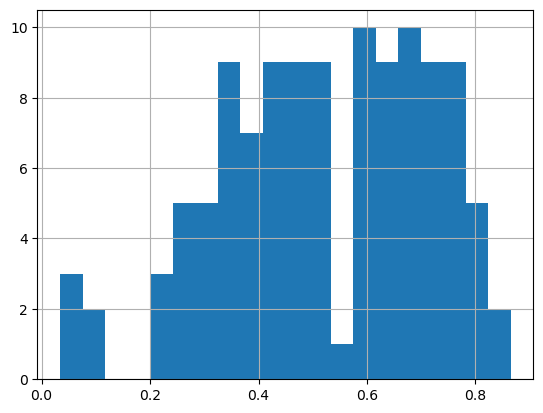

In [32]:
# print a histogram of the iou scores
results_merged["iou"].hist(bins=20)
plt.show()

Boxplots: 

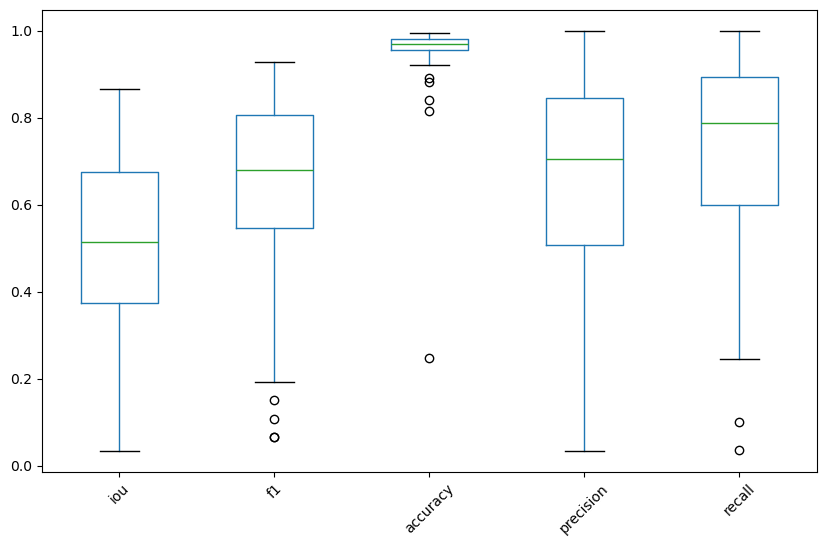

In [33]:
# create boxplots of the iou scores
results_merged.boxplot(column=["iou", "f1", "accuracy", "precision", "recall"], figsize=(10, 6), rot=45, grid=False)
plt.show()

IoU per tile on the map: 

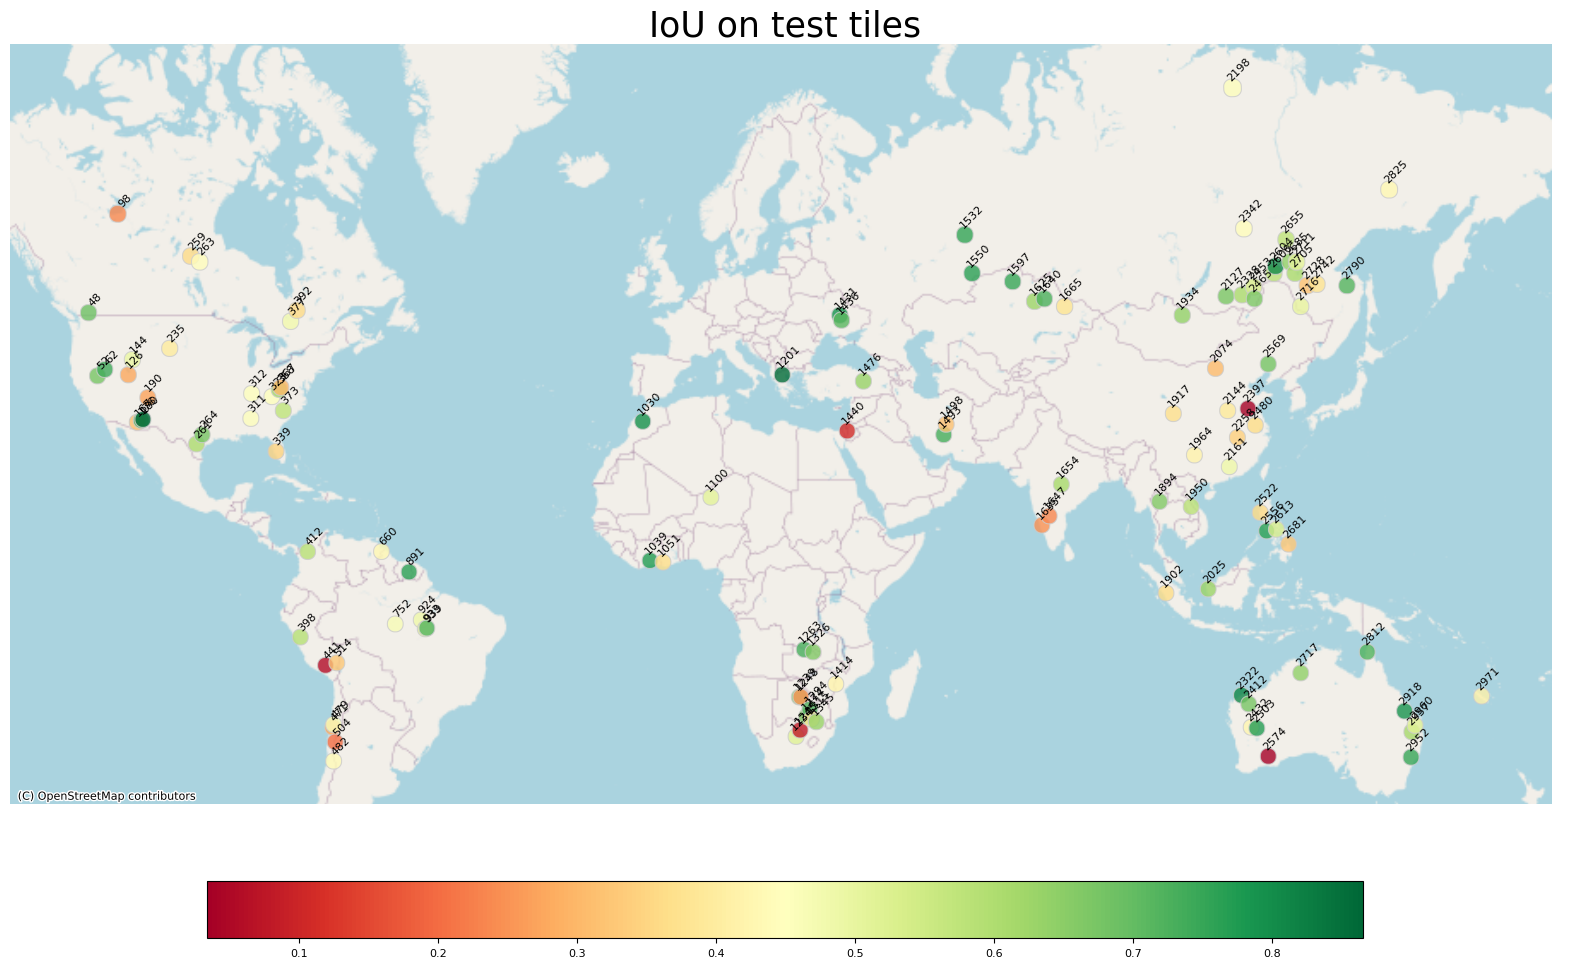

In [34]:
results_merged_gdf = gpd.GeoDataFrame(results_merged, geometry=results_merged["geometry"])

plot_iou_on_test_tiles(results_merged_gdf, add_tile_id = True)

### 3. On the whole test set tile, using validated mining areas

This allows us to see if the model performs better or worse on a set of validated polyons

Calculate the metrics: 

In [35]:
# calculate the batch size, so that one batch includes all chips for a tile
batch_size_tile = int((2048/CHIP_SIZE)**2)
print(f"Batch size: {batch_size_tile}")

results = calculate_metrics(model, TEST_CHIP_VALIDATED_DIR, TEST_LABEL_VALIDATED_DIR, batch_size_tile, calculate_per_tile=True)

Batch size: 16
Temporary chip directory: /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/validated/temp/chips/
Temporary label directory: /teamspace/studios/this_studio/workspaces/mine-segmentation/data/processed/chips/npy/512/validated/temp/labels/
Number of unique tile ids: 116


  1%|          | 1/116 [00:06<11:46,  6.14s/it]

100%|██████████| 116/116 [11:14<00:00,  5.81s/it]


Per-Tile metrics: 

In [36]:
# load the processed dataset
tiles = gpd.read_file(DATASET, layer="tiles")
test_tiles = tiles[tiles["split"] == "test"]

# extract the tile_id from the file_name
results["tile_id"] = results["file_name"].apply(lambda x: x.split("_")[0])

# convert tile_id to int
results['tile_id'] = results['tile_id'].astype(int)

# Merge the results with the test_tiles
results_merged = results.merge(test_tiles[["tile_id", "preferred_dataset", "minetype1", "minetype2", "geometry"]], on='tile_id')

# # save as csv in the reports folder
output_path = output_dir + "/testset_metrics_per_tile.csv"
results_merged.to_csv(output_path, index=False)
print(f"Saved aggregated metrics to {output_path}")

# calculate overall metrics
iou = results_merged["iou"].mean()
f1 = results_merged["f1"].mean()
accuracy = results_merged["accuracy"].mean()
recall = results_merged["recall"].mean()
precision = results_merged["precision"].mean()

# print the results
print(f"Mean IoU: {iou}")
print(f"Mean F1: {f1}")
print(f"Mean Accuracy: {accuracy}")
print(f"Mean Recall: {recall}")
print(f"Mean Precision: {precision}")
results_merged[['tile_id', 'preferred_dataset', 'minetype1', 'minetype2', 'iou', 'f1', 'accuracy', 'recall', 'precision']]

Saved aggregated metrics to /teamspace/studios/this_studio/workspaces/mine-segmentation/reports/cnn/mineseg-cnn_epoch-16_val-iou-05731/testset_metrics_per_tile.csv
Mean IoU: 0.5357178257528181
Mean F1: 0.6747683280288309
Mean Accuracy: 0.9594416590942734
Mean Recall: 0.7361976896145903
Mean Precision: 0.6916412240109983


tile_id preferred_dataset minetype1   minetype2       iou        f1  \
0       1030              tang   Surface  Industrial  0.797983  0.887642   
1       1039              maus   Surface  Industrial  0.769518  0.869749   
2       1051              maus    Placer   Artisanal  0.376063  0.546578   
3       1100              tang   Surface  Industrial  0.508950  0.674575   
4       1201              tang   Surface  Industrial  0.875224  0.933461   
..       ...               ...       ...         ...       ...       ...   
111      891              maus    Placer   Artisanal  0.762563  0.865289   
112      924              maus   Surface   Artisanal  0.482729  0.651136   
113      933              maus   Surface   Artisanal  0.542092  0.703061   
114      939              maus    Placer   Artisanal  0.744168  0.853321   
115       98              tang   Surface  Industrial  0.243482  0.391614   

     accuracy    recall  precision  
0    0.935379  0.941129   0.839908  
1    0.994148  0.830557   0.912823  
2    0.935627  0.695009   0.450390  
3    0.927805  0.949837   0.523008  
4    0.983021  0.990563   0.882584  
..        ...       ...        ...  
111  0.945777  0.767141   0.992235  
112  0.957938  0.551100   0.795542  
113  0.979784  0.850357   0.599259  
114  0.985082  0.892832   0.817159  
115  0.892888  0.995593   0.243745  

[116 rows x 9 columns]

Grouped metrics: 

In [37]:
print_grouped_metrics(results_merged)

Metrics per mine type (minetype1):
           count       iou        f1  accuracy    recall  precision
minetype1                                                          
Placer        13  0.559773  0.704915  0.961573  0.662172   0.810707
Surface      103  0.532682  0.670963  0.959173  0.745541   0.676613
-----------------------------------------------
Metrics per mine type (minetype2):
            count       iou        f1  accuracy    recall  precision
minetype2                                                           
Artisanal      21  0.531476  0.679647  0.961148  0.653329   0.771460
Industrial     95  0.536656  0.673690  0.959064  0.754516   0.673997
-----------------------------------------------
Metrics per dataset (preferred_dataset):
                   count       iou        f1  accuracy    recall  precision
preferred_dataset                                                          
maus                  57  0.549215  0.688862  0.950133  0.704115   0.740677
tang             

Histogram: 

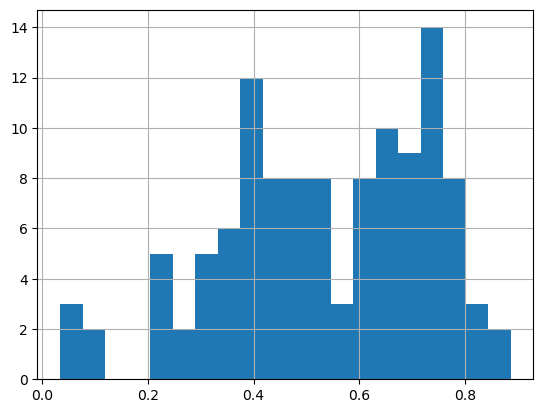

In [38]:
# print a histogram of the iou scores
results_merged["iou"].hist(bins=20)
plt.show()

Boxplots: 

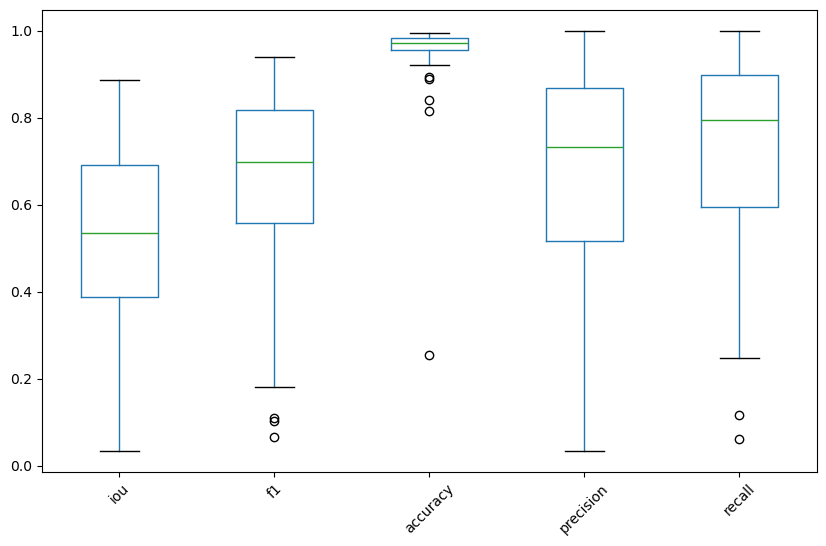

In [39]:
# create boxplots of the iou scores
results_merged.boxplot(column=["iou", "f1", "accuracy", "precision", "recall"], figsize=(10, 6), rot=45, grid=False)
plt.show()

IoU per tile on the map: 

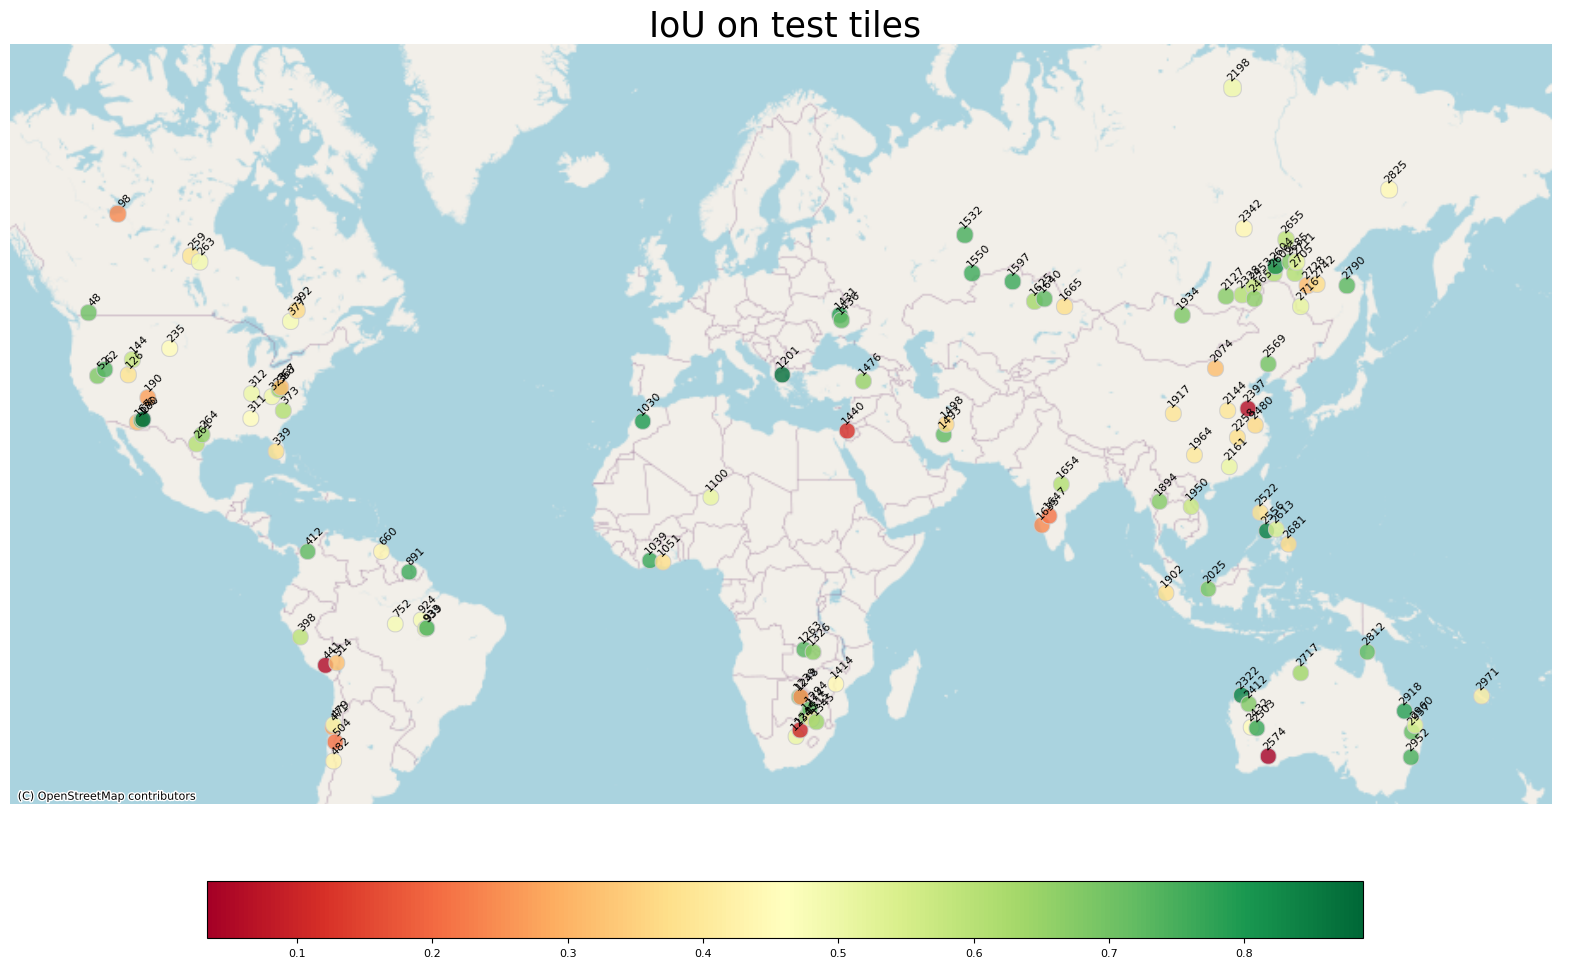

In [40]:
results_merged_gdf = gpd.GeoDataFrame(results_merged, geometry=results_merged["geometry"])

plot_iou_on_test_tiles(results_merged_gdf, add_tile_id = True)

## Plot individual tiles and predictions
You can check the dataframe above (results_merged), and indicate the index that should be displayed. 

In [49]:
tile_ids = [1100, 412, 126]
print(f"Visualizing tile_ids {tile_ids}")
batch_size_tile = int((2048/CHIP_SIZE)**2)
print(f"Batch size: {batch_size_tile}")

Visualizing tile_ids [1100, 412, 126]
Batch size: 16


Using unvalidated chips
Using tile_id 1100, with filename 1100_S2B_MSIL2A_20201216T100329_R122_T32QLF_20210105T215356


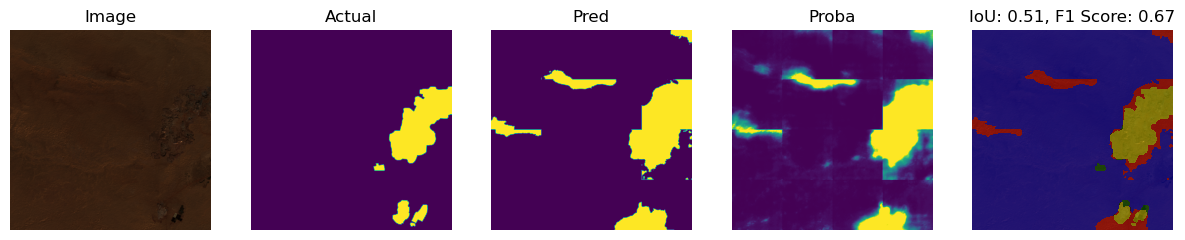

<Figure size 640x480 with 0 Axes>

Using validated chips
Using tile_id 1100, with filename 1100_S2B_MSIL2A_20201216T100329_R122_T32QLF_20210105T215356


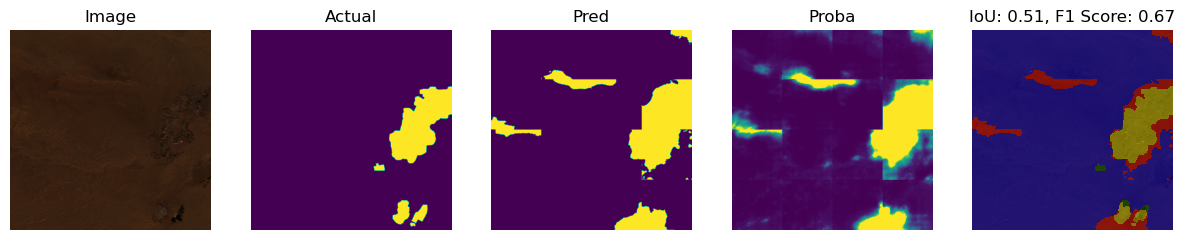

<Figure size 640x480 with 0 Axes>

Using unvalidated chips
Using tile_id 412, with filename 412_S2B_MSIL2A_20171218T153609_R068_T18NVP_20201014T145924


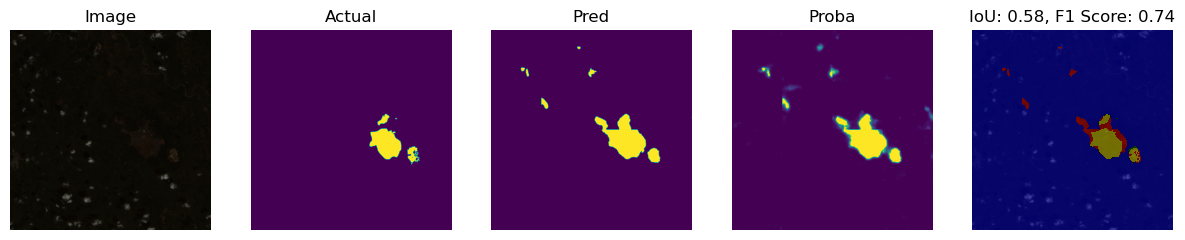

<Figure size 640x480 with 0 Axes>

Using validated chips
Using tile_id 412, with filename 412_S2B_MSIL2A_20171218T153609_R068_T18NVP_20201014T145924


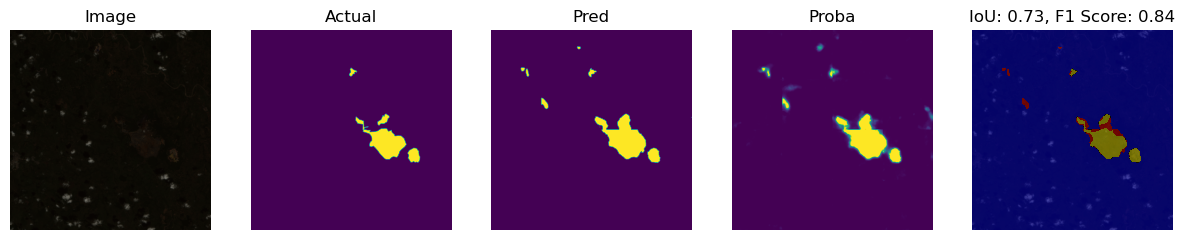

<Figure size 640x480 with 0 Axes>

Using unvalidated chips
Using tile_id 126, with filename 126_S2B_MSIL2A_20191109T181549_R084_T12TUK_20201003T145429


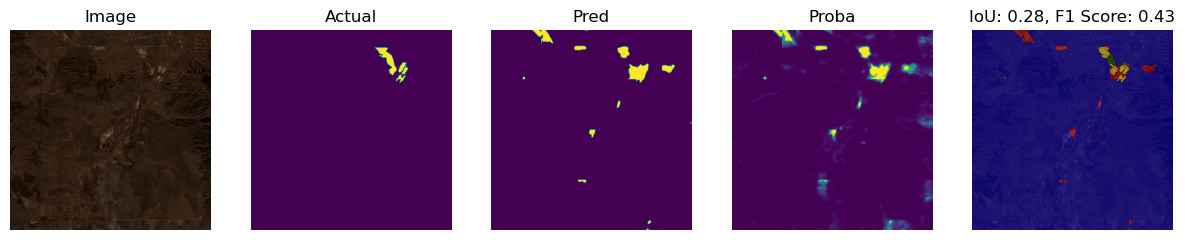

<Figure size 640x480 with 0 Axes>

Using validated chips
Using tile_id 126, with filename 126_S2B_MSIL2A_20191109T181549_R084_T12TUK_20201003T145429


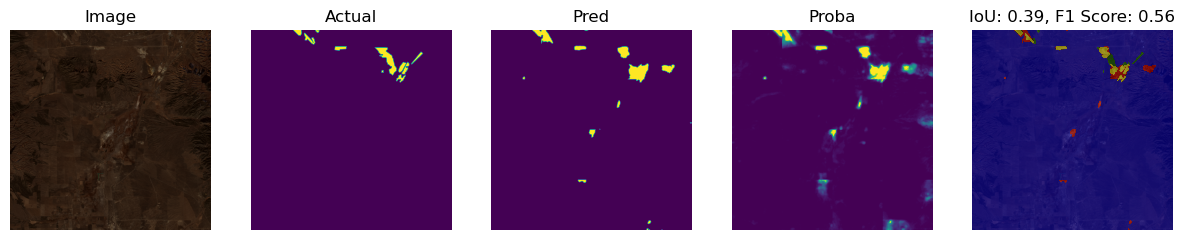

<Figure size 640x480 with 0 Axes>

In [51]:
for tile_id in tile_ids:
    for chip_dir in [[TEST_CHIP_DIR, TEST_LABEL_DIR], [TEST_CHIP_VALIDATED_DIR, TEST_LABEL_VALIDATED_DIR]]:
        chip_dir, label_dir = chip_dir
        if "validated" in chip_dir:
            print("Using validated chips:")
        else:
            print("Using unvalidated chips:")

        # Create a new directory at the same level as TEST_CHIP_DIR with the name temp
        greatgrandparent_dir = os.path.dirname(os.path.dirname(os.path.dirname(chip_dir)))
        temp_dir = os.path.join(greatgrandparent_dir, "temp")
        Path(os.path.join(temp_dir, "chips")).mkdir(parents=True, exist_ok=True)
        Path(os.path.join(temp_dir, "labels")).mkdir(parents=True, exist_ok=True)

        temp_chip_dir = os.path.join(temp_dir, "chips/")
        temp_label_dir = os.path.join(temp_dir, "labels/")



        file_name = copy_files_to_temp_directory(tile_id, chip_dir, label_dir, temp_chip_dir, temp_label_dir)
        print(f"Using tile_id {tile_id}, with filename {file_name}")

        # Get data
        batch, metadata = get_data(
            TRAIN_CHIP_DIR,
            TRAIN_LABEL_DIR,
            VAL_CHIP_DIR,
            VAL_LABEL_DIR,
            temp_chip_dir,
            temp_label_dir,
            METADATA_PATH,
            batch_size_tile,
            NUM_WORKERS,
            PLATFORM,
            data_augmentation=False,
            index=0
        )

        # Move batch to GPU
        if torch.cuda.is_available():
            batch = {k: v.to("cuda") for k, v in batch.items()}

        # Run prediction
        outputs = run_prediction(model, batch, is_clay=CLAY)

        # list all files in the temp directory
        temp_chips = os.listdir(temp_chip_dir)

        # extract the chip number
        chip_num = [int(chip.split("_")[9].split(".")[0]) for chip in temp_chips]

        images = []
        labels = []
        probas = []
        preds = []

        # Iterate over the indices in the batch
        for i in range(len(chip_num)):
            index = chip_num.index(i)
            # print(f"Processing chip {temp_chips[index]}")
            # Post-process the results
            image, label, proba, pred = post_process(batch, outputs, metadata, index=index)
            images.append(image)
            labels.append(label)
            probas.append(proba.squeeze())
            preds.append(pred.squeeze())

        # Combine the 16 images into a single 2048x2048 image
        def put_np_together(images, channels=3, chip_size=512):
            if channels == 1:
                big_image = np.zeros((2048, 2048))
            elif channels == 3:
                big_image = np.zeros((2048, 2048, 3))

            # Define the chip size and the number of chips in each dimension
            chip_size = chip_size
            n_chips_x = 2048 // chip_size
            n_chips_y = 2048 // chip_size

            # Iterate over the 16 images and place them in the correct position
            chip_number = 0
            for i in range(n_chips_x):  # Iterate over columns
                for j in range(n_chips_y):  # Iterate over rows
                    x1, y1 = j * chip_size, i * chip_size
                    x2, y2 = x1 + chip_size, y1 + chip_size
                    if channels == 1:
                        big_image[x1:x2, y1:y2] = images[chip_number]
                    else:
                        big_image[x1:x2, y1:y2, :] = images[chip_number]
                    chip_number += 1

            return big_image

        big_image = put_np_together(images, channels=3, chip_size=CHIP_SIZE)
        big_label = put_np_together(labels, channels=1, chip_size=CHIP_SIZE)
        big_proba = put_np_together(probas, channels=1, chip_size=CHIP_SIZE)
        big_pred = put_np_together(preds, channels=1, chip_size=CHIP_SIZE)

        plot_predictions(big_image, big_label, big_proba, big_pred)

In [52]:
# plot_pred_vs_true_mask(big_image, big_label, big_pred, add_legend=False)

In [53]:
# REMEMBER TO SAVE THE NOTEBOOK BEFORE RUNNING THIS CELL!!!!
nb_path = root + "/notebooks/cnn/cnn_inference.ipynb"
output_dir_report = output_dir + "/"
print(f"Exporting notebook to {output_dir_report}")

# export the notebook to reports
!jupyter nbconvert --to html $nb_path --output-dir=$output_dir_report --output="CNN_testset_evaluation.html" --no-input --no-prompt

Exporting notebook to /teamspace/studios/this_studio/workspaces/mine-segmentation/reports/cnn/mineseg-cnn_epoch-16_val-iou-05731/
[NbConvertApp] Converting notebook /teamspace/studios/this_studio/workspaces/mine-segmentation/notebooks/cnn/cnn_inference.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 21 image(s).
[NbConvertApp] Writing 4581363 bytes to /teamspace/studios/this_studio/workspaces/mine-segmentation/reports/cnn/mineseg-cnn_epoch-16_val-iou-05731/CNN_testset_evaluation.html
